In [69]:
import pandas as pd
import numpy as np

## for visualisation ##
import matplotlib.pyplot as plt
import seaborn as sns


## for modelling ##
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error


## oversampling ##
from imblearn.over_sampling import SMOTE


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [81]:
hcdata = pd.read_csv('hcdata_encoded.csv')

In [82]:
X = hcdata.drop(['Category_coded', 'AgeGroup', 'Unnamed: 0'], axis=1)
y = hcdata['Category_coded']

In [83]:
hcdata.isnull().sum()

Unnamed: 0        0
Age               0
ALB               0
ALP               0
ALT               0
AST               0
BIL               0
CHE               0
CHOL              0
CREA              0
GGT               0
PROT              0
Category_coded    0
Sex_coded         0
AgeGroup          0
dtype: int64

### Using whole data

#### without filling imbalanced data

### a function to plot the coefficients

In [87]:
def view_coeff(X, model):
    
    for i in range(len(model.coef_)):
        model_coefs = pd.DataFrame({'variable': X.columns,
                                    'coef': model.coef_[i],
                                    'abs_coef': np.abs(model.coef_[i])})
        model_coefs.sort_values('abs_coef', inplace=True, ascending=False)
        plt.figure(figsize=(10,10))
        sns.barplot(x="variable", y="coef", data=model_coefs)
        plt.title('Class: T=%i' %i)
        plt.xticks(rotation=70)
        plt.tight_layout()

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [85]:
logreg = LogisticRegression(multi_class='ovr',solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [86]:
logreg.coef_

array([[-0.00288297,  0.21465385,  0.06728109, -0.00231856, -0.04421951,
        -0.06379722, -0.10403128,  0.59669627, -0.02030116, -0.03415907,
        -0.09346966,  0.6102744 ],
       [ 0.56561227, -0.90630307, -0.06948175,  0.00413971, -0.28736858,
         0.03701497,  0.17412235, -0.0426428 , -0.21112915,  0.14703519,
         0.12134943,  0.17022264],
       [-0.10450309,  0.04373171, -0.10330968, -0.01737331,  0.01438072,
         0.02730605,  0.34537905,  0.05854346, -0.02786164,  0.01392706,
         0.03373556, -0.04523681],
       [ 0.08991425, -0.11597554, -0.2800387 ,  0.03970142,  0.01414825,
        -0.11917907,  0.71278721, -0.38831947, -0.07619376,  0.02813529,
         0.12516458, -0.83109075],
       [-0.01668193, -0.2351042 , -0.0202412 ,  0.01333221,  0.0131025 ,
         0.04830567, -0.77521314,  0.27722071,  0.02595452, -0.00216933,
         0.09725773,  0.14853099]])

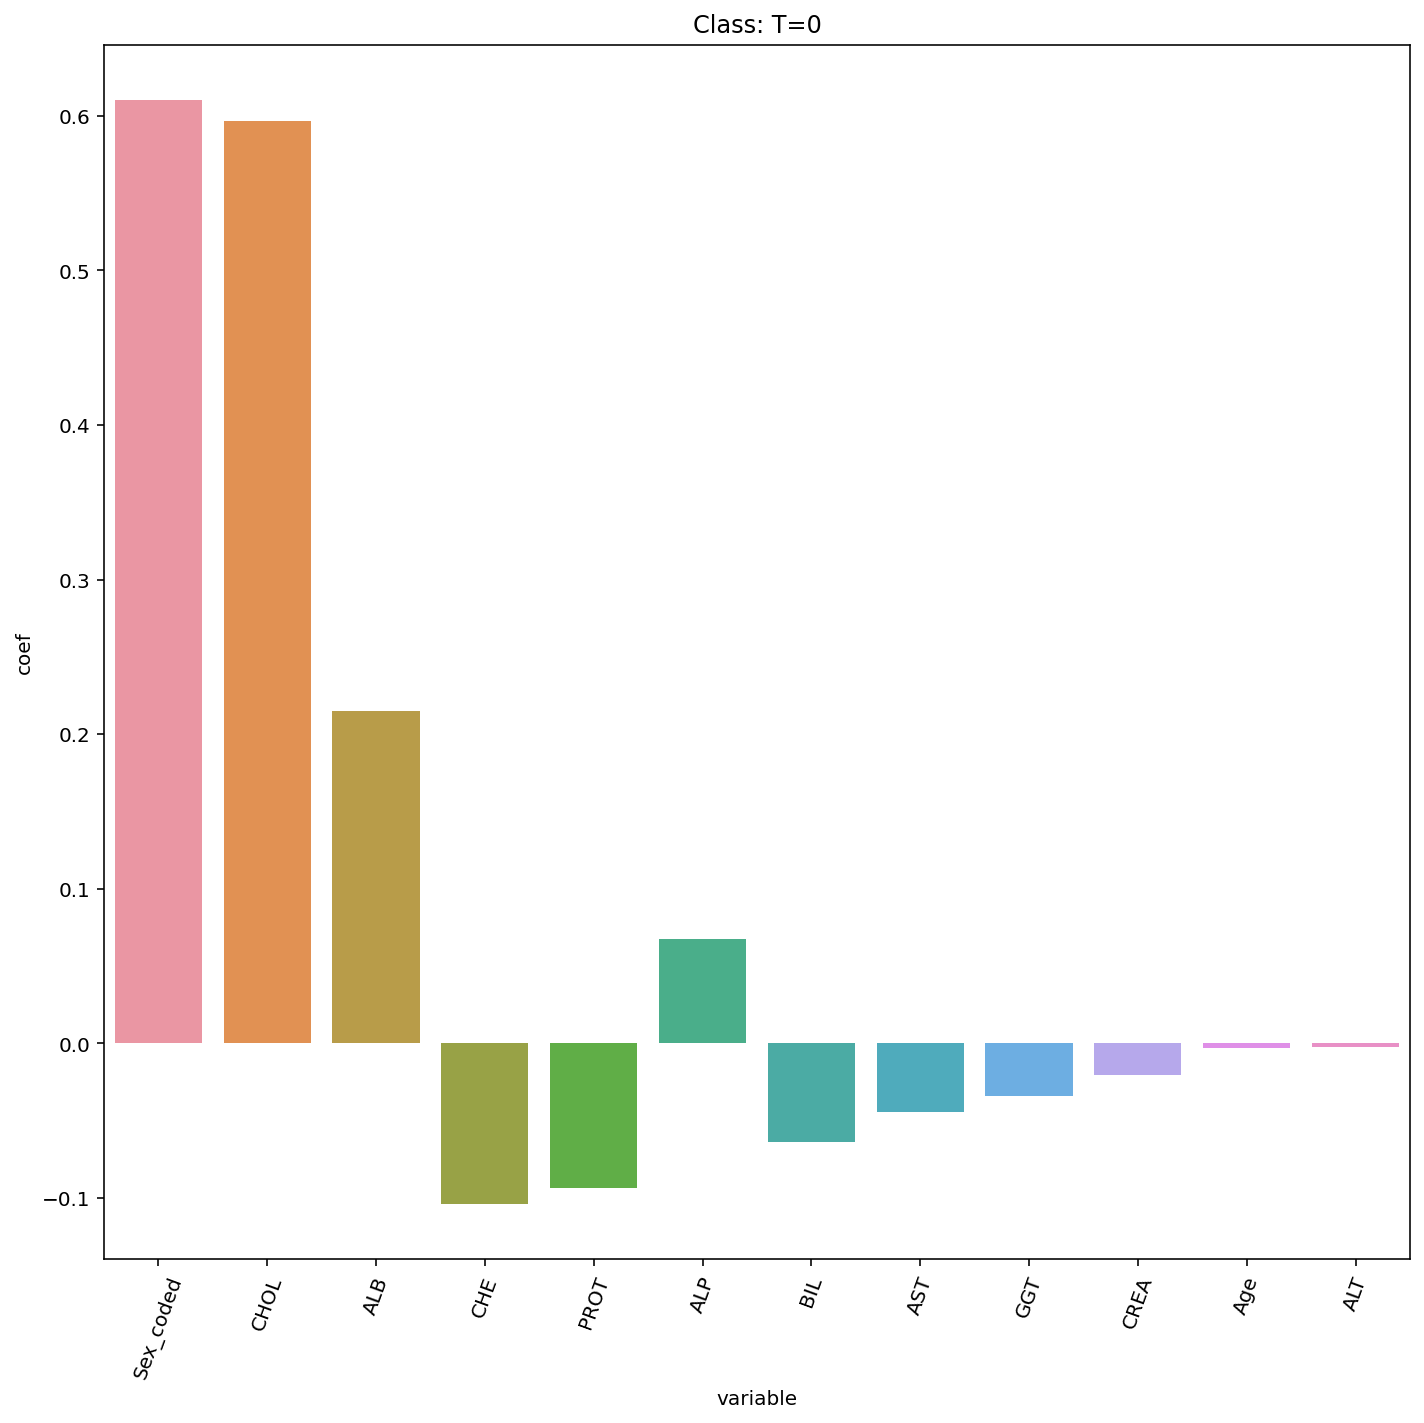

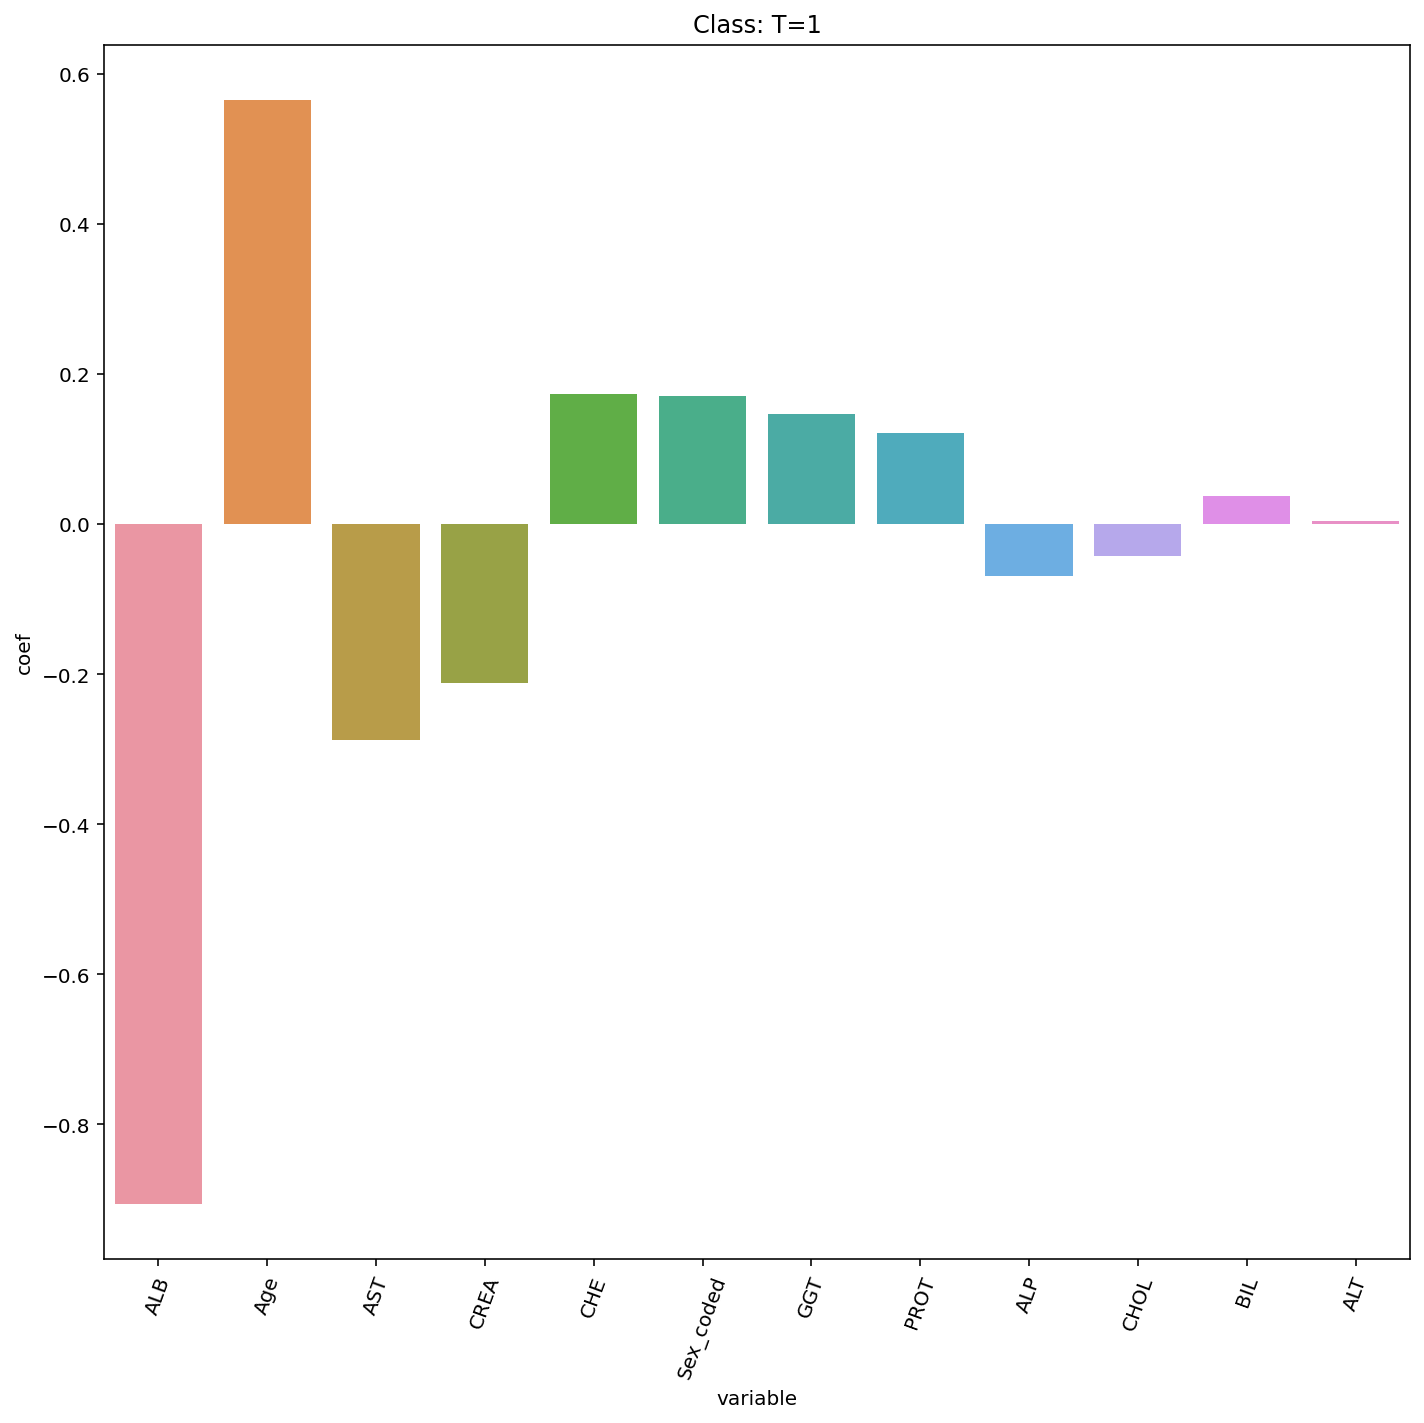

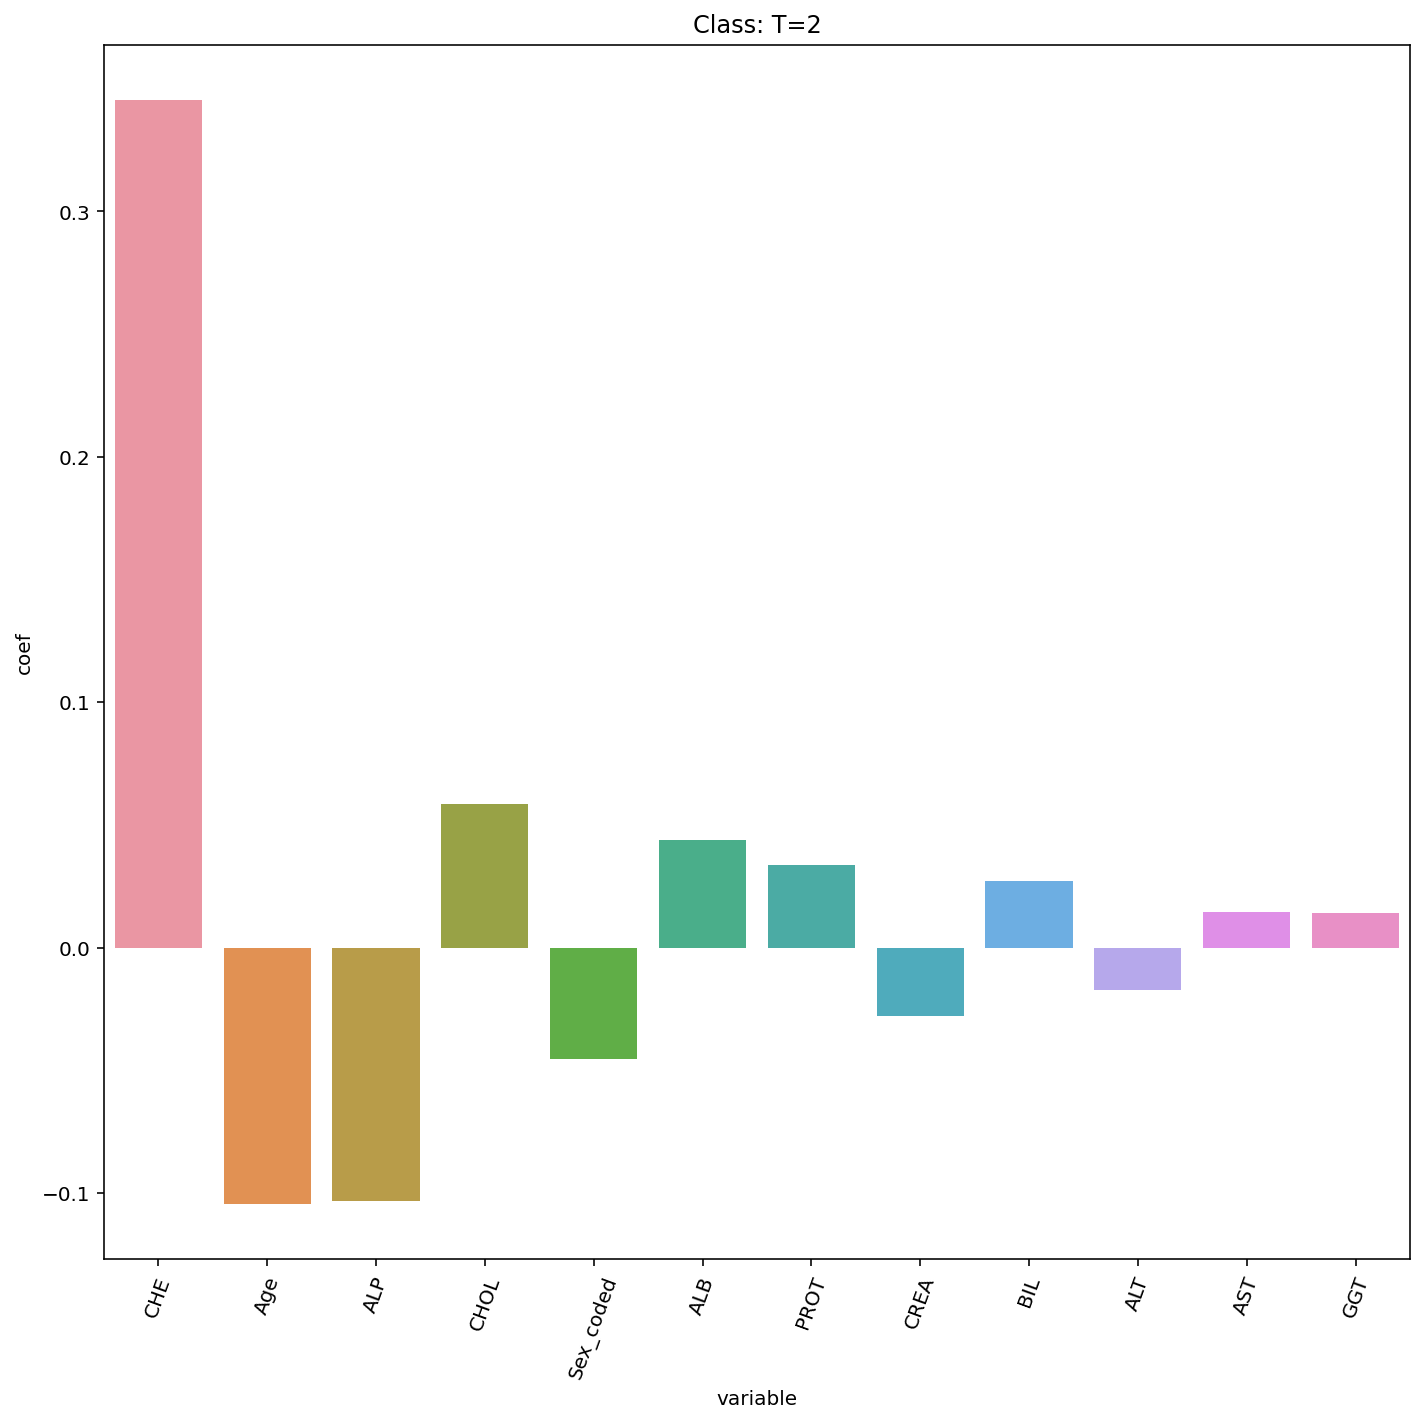

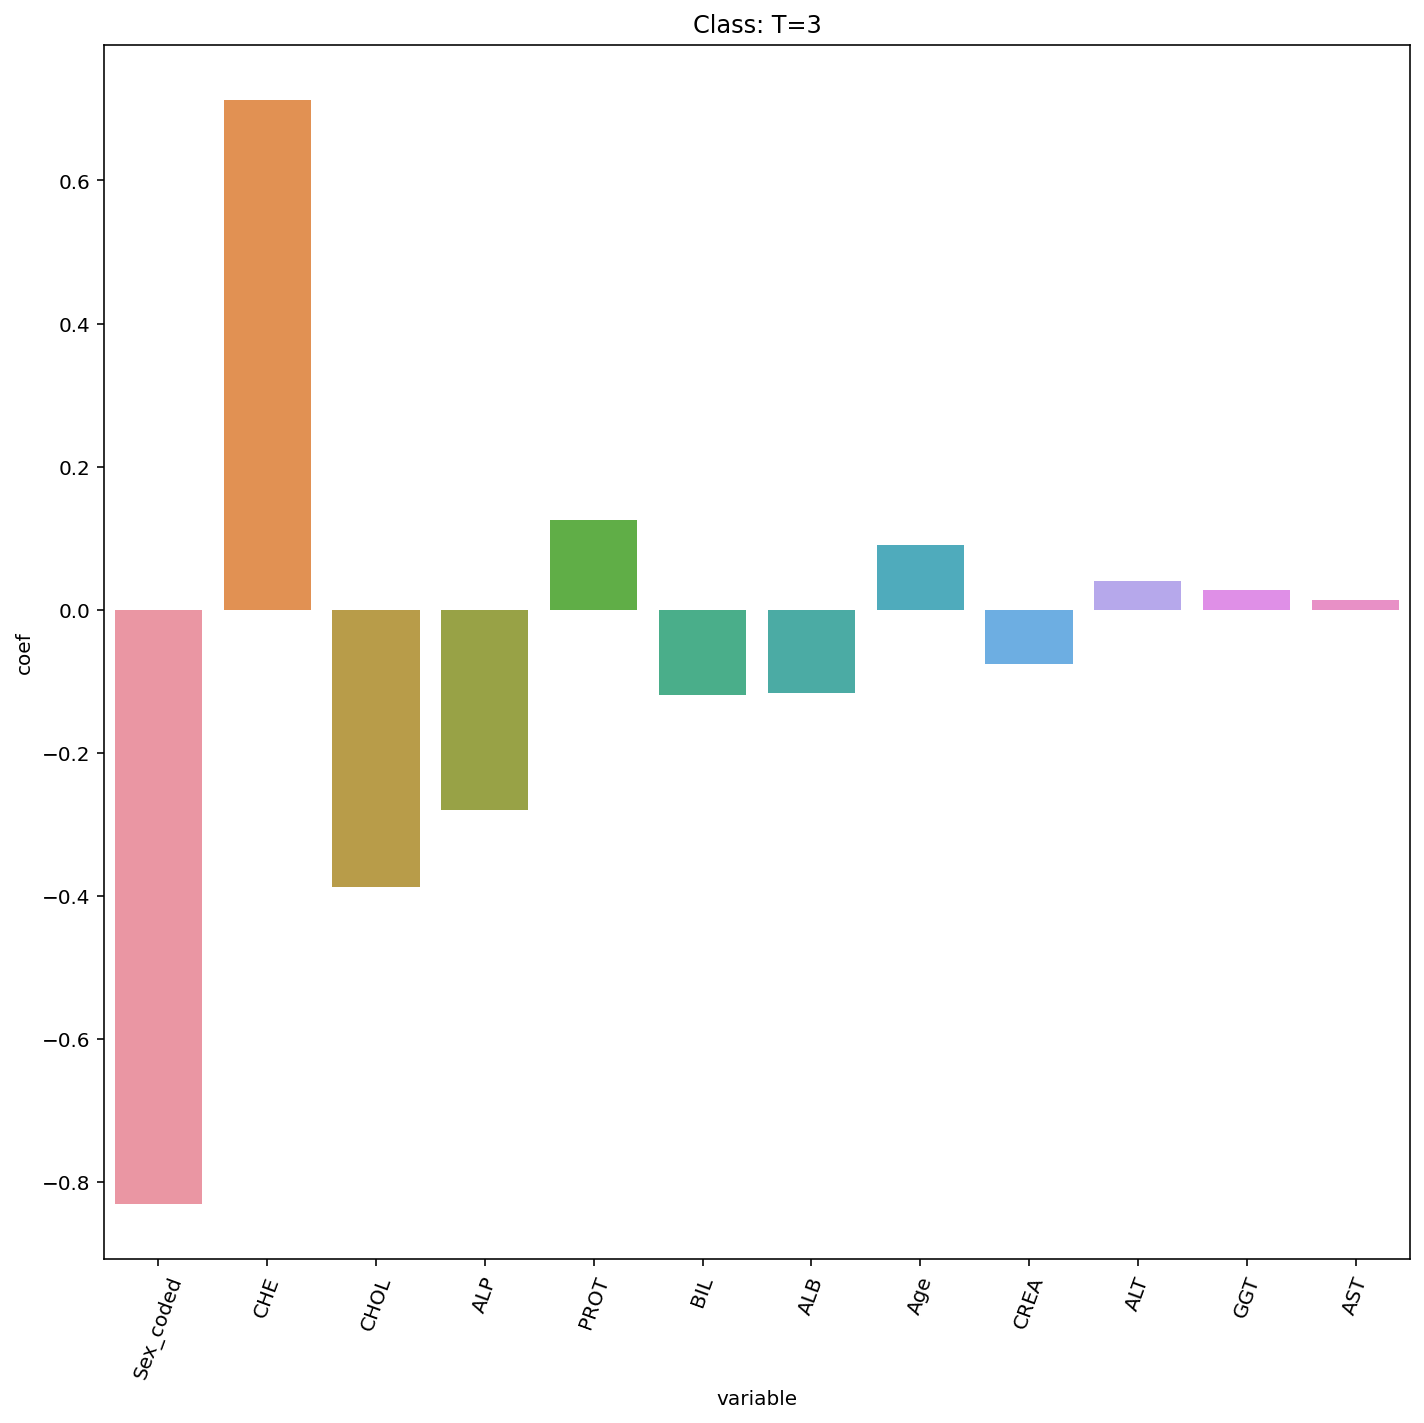

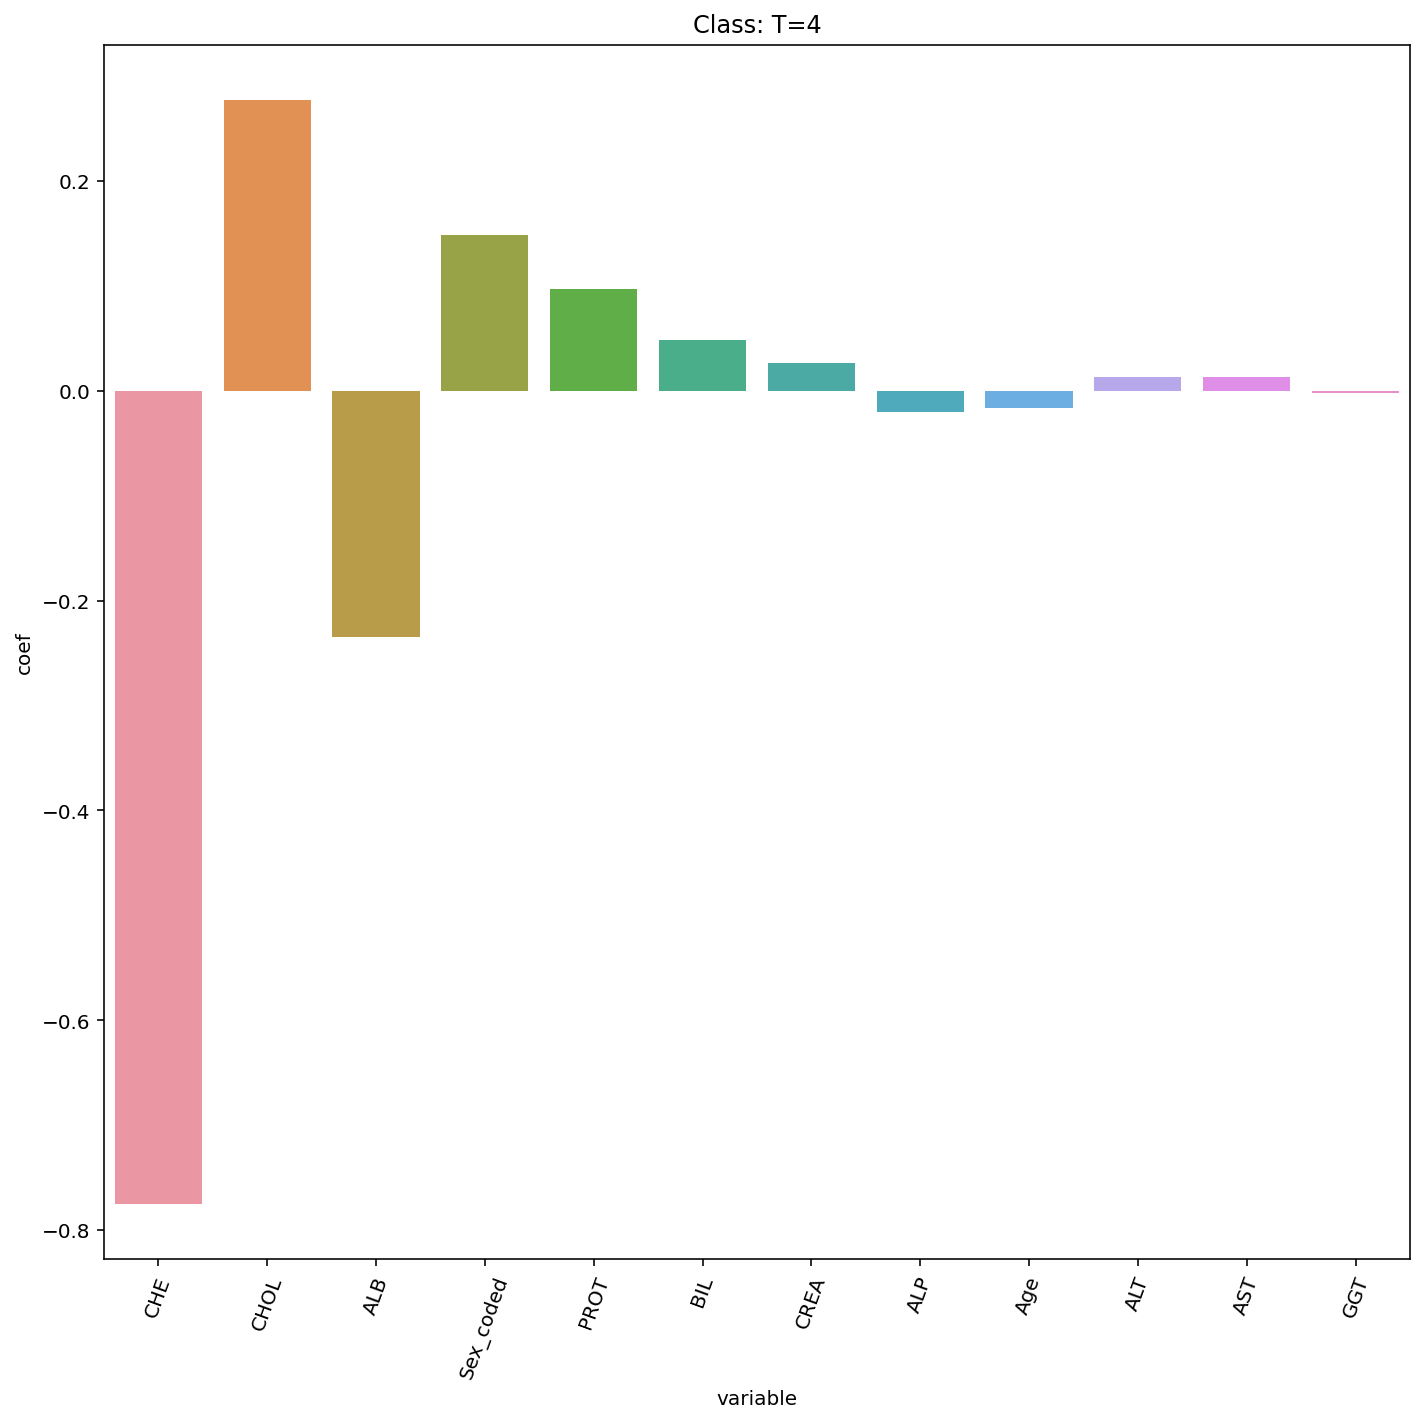

In [92]:
view_coeff(X, logreg)

In [34]:
scores = cross_val_score(logreg, X, y, cv=5)
scores.mean()

0.9268292682926829

In [90]:
### using RidgeClassifier to see the coeff ##
optimal_ridge = RidgeClassifier(normalize=True)
optimal_ridge.fit(X_train, y_train)
print('Score:', optimal_ridge.score(X, y))

Score: 0.8910569105691057


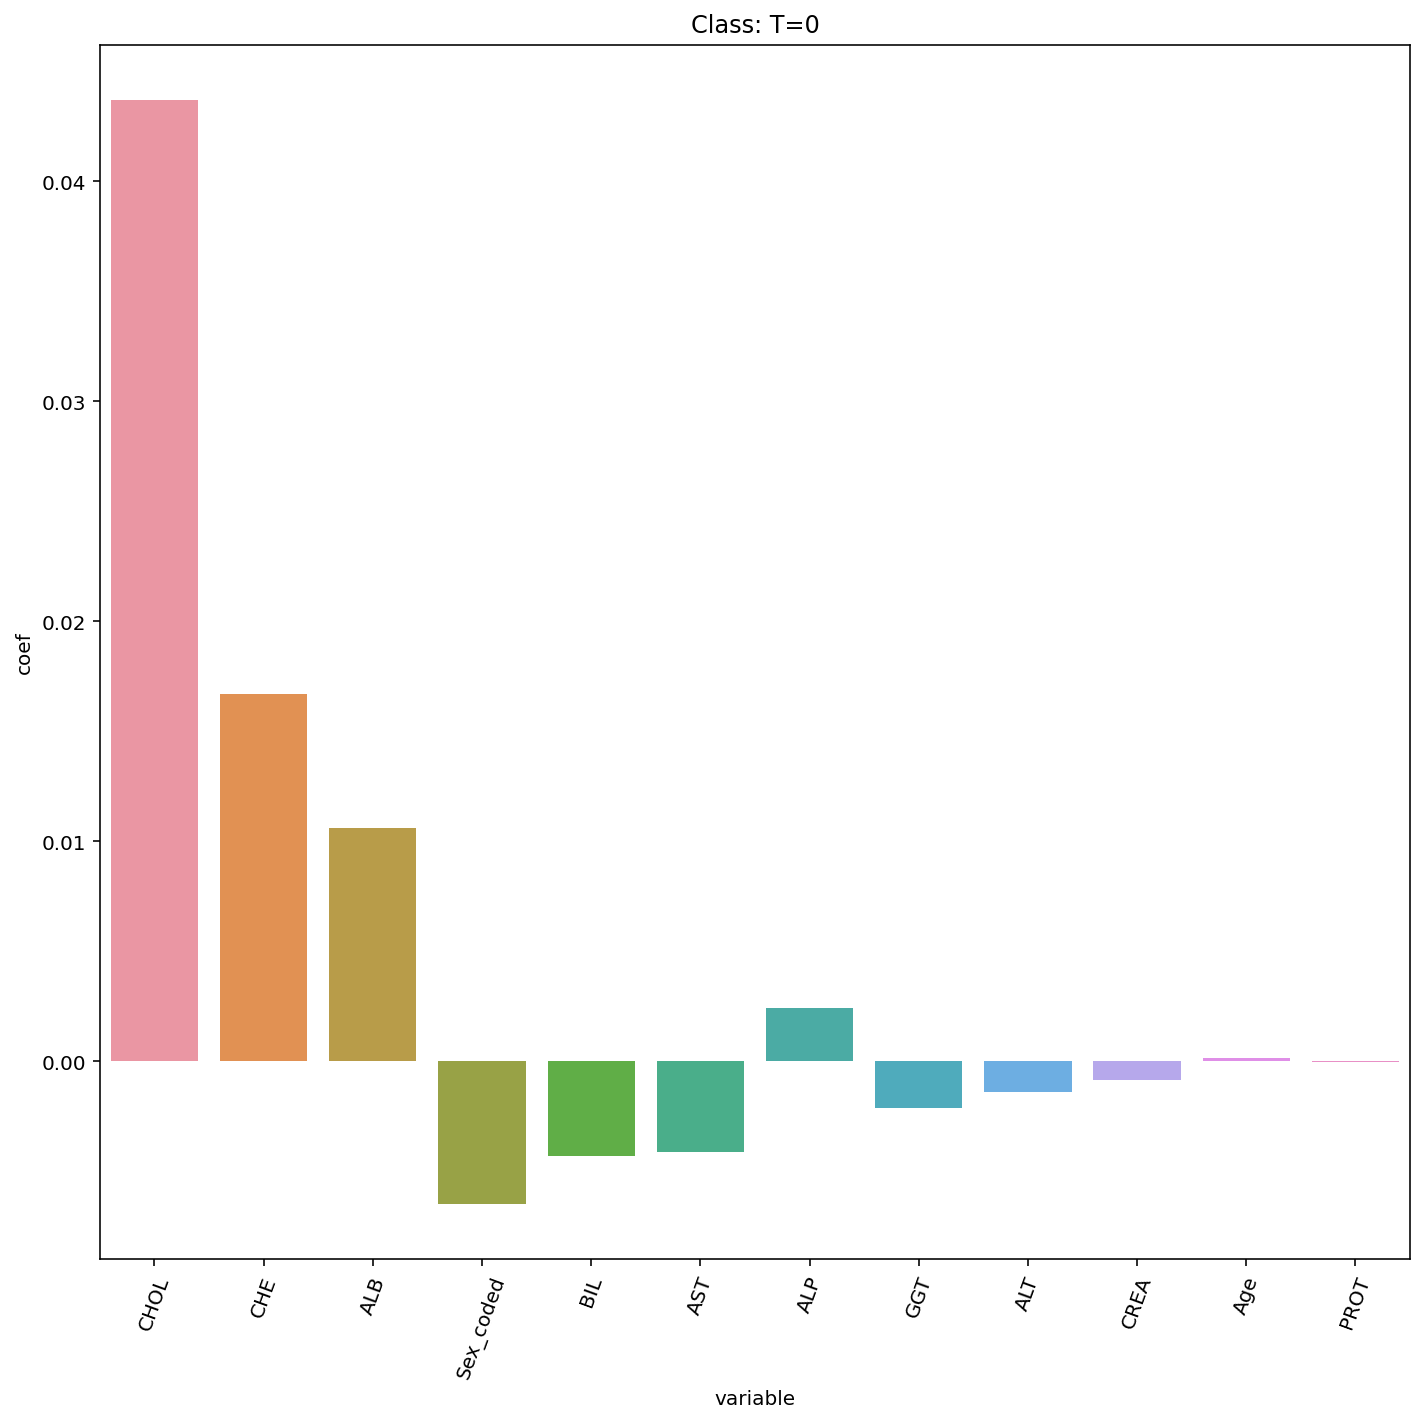

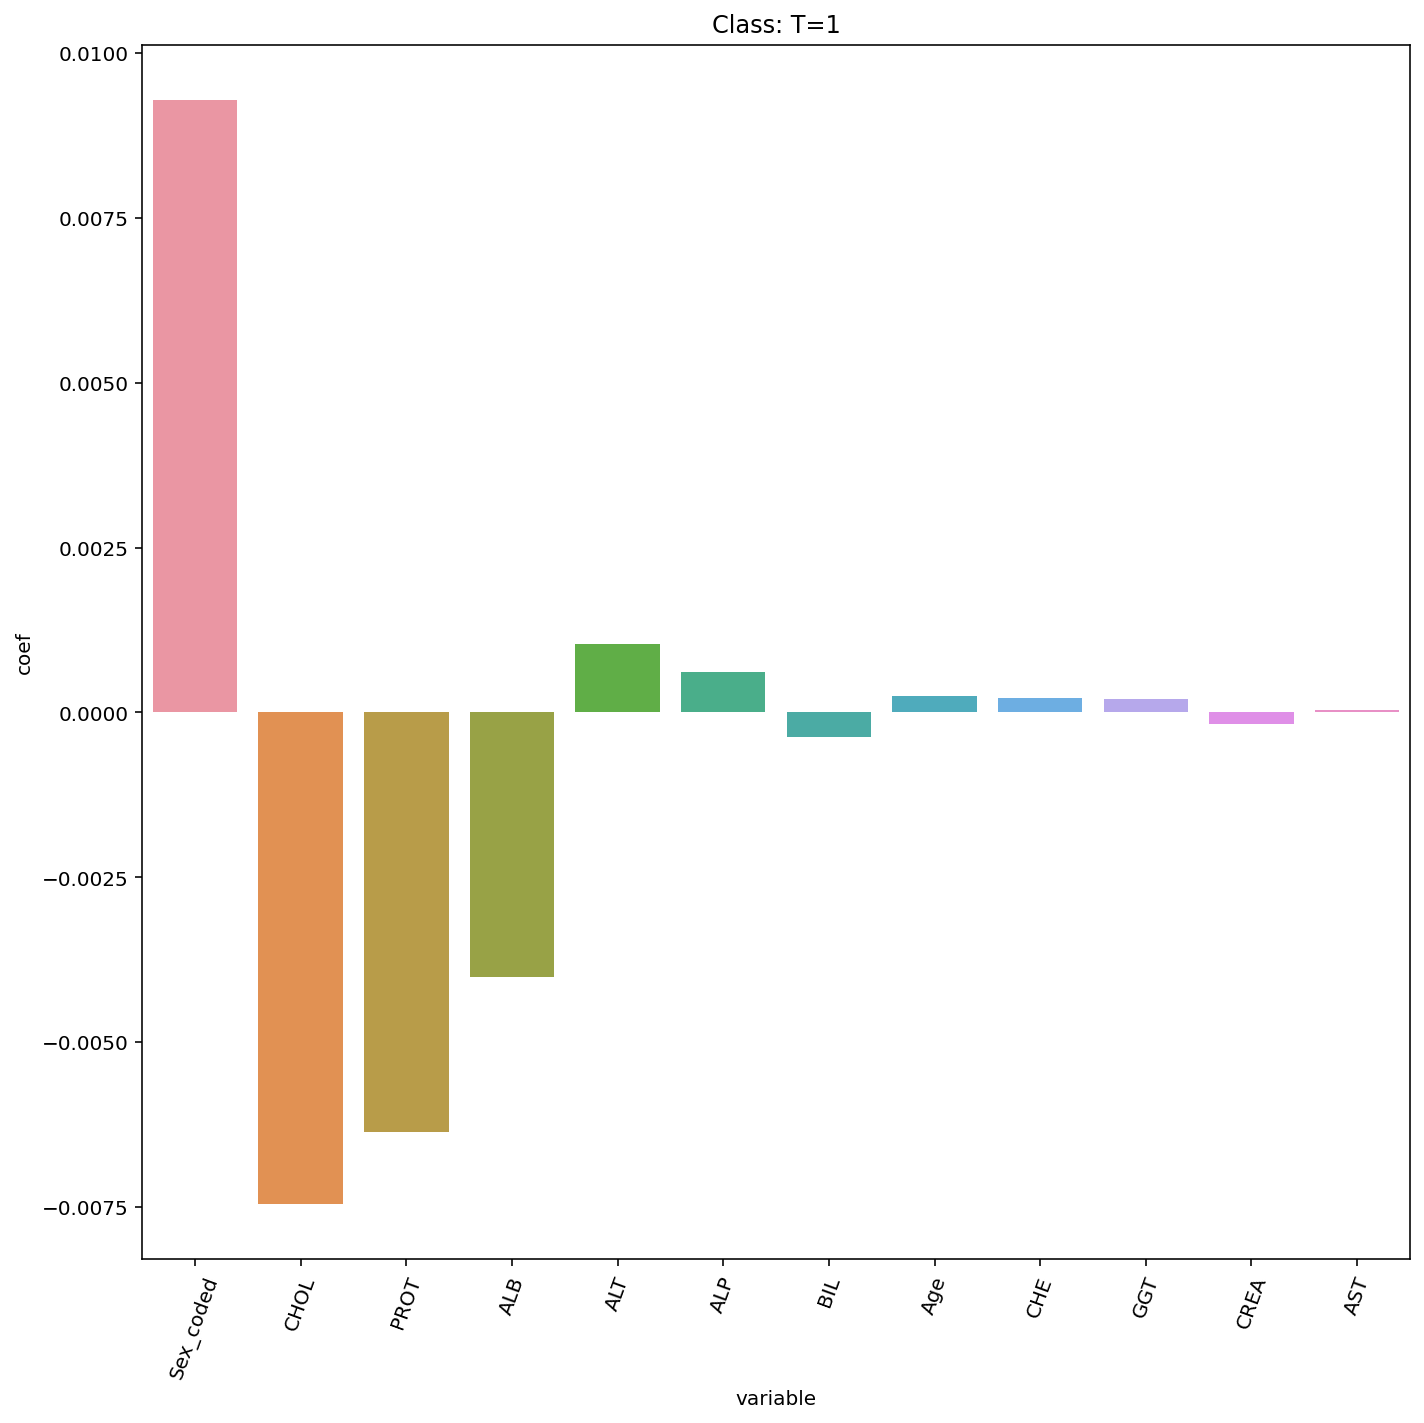

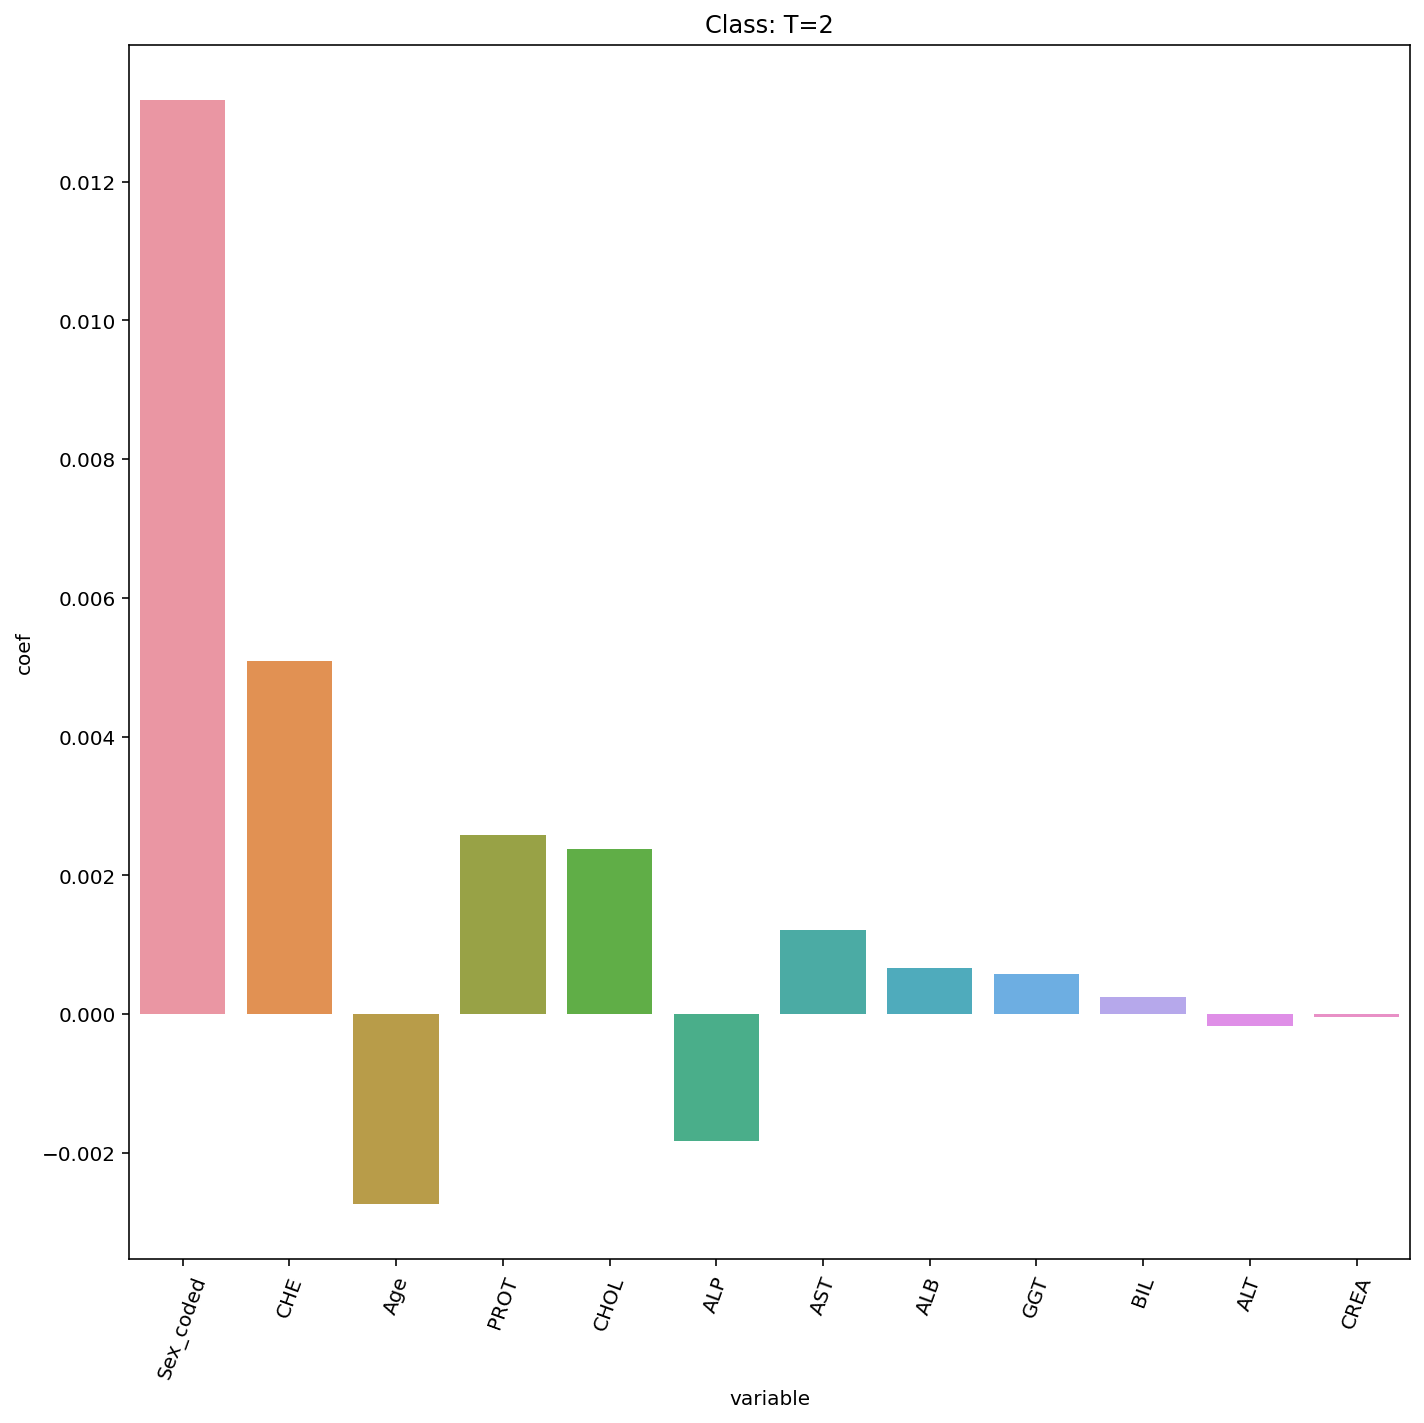

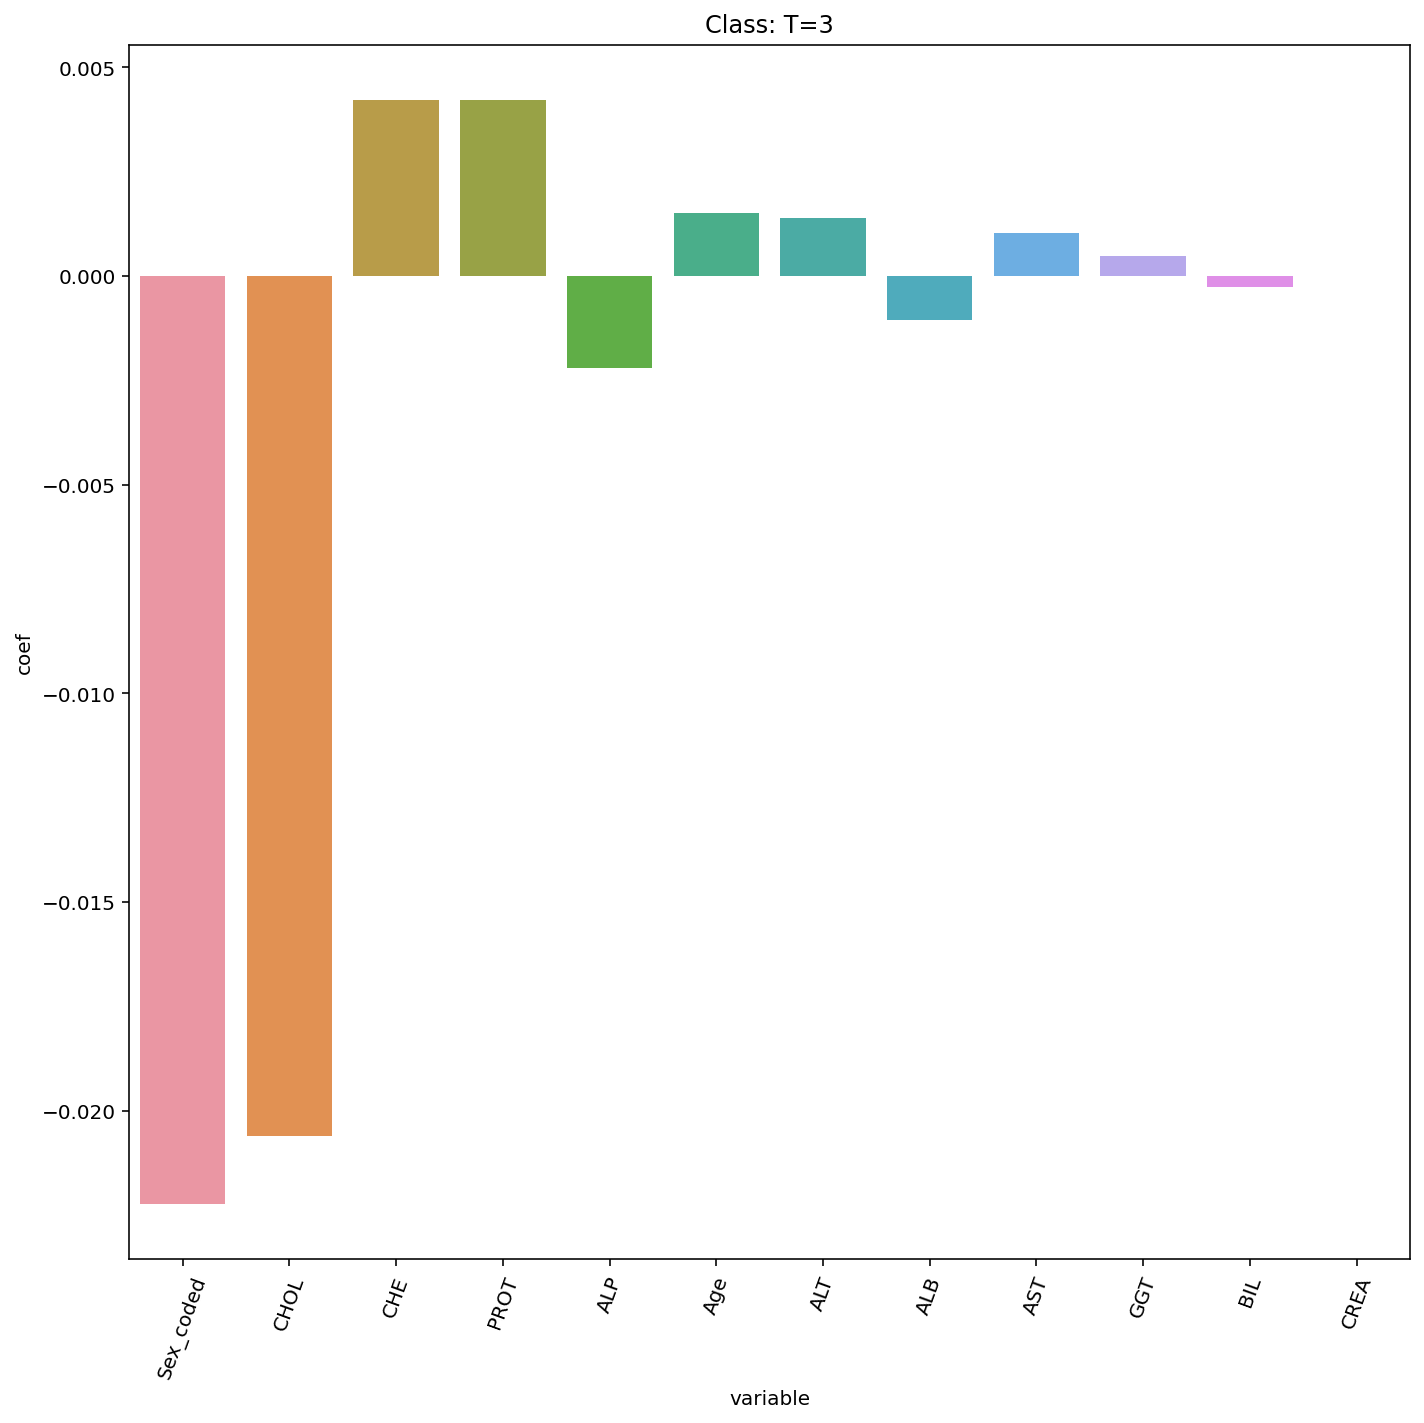

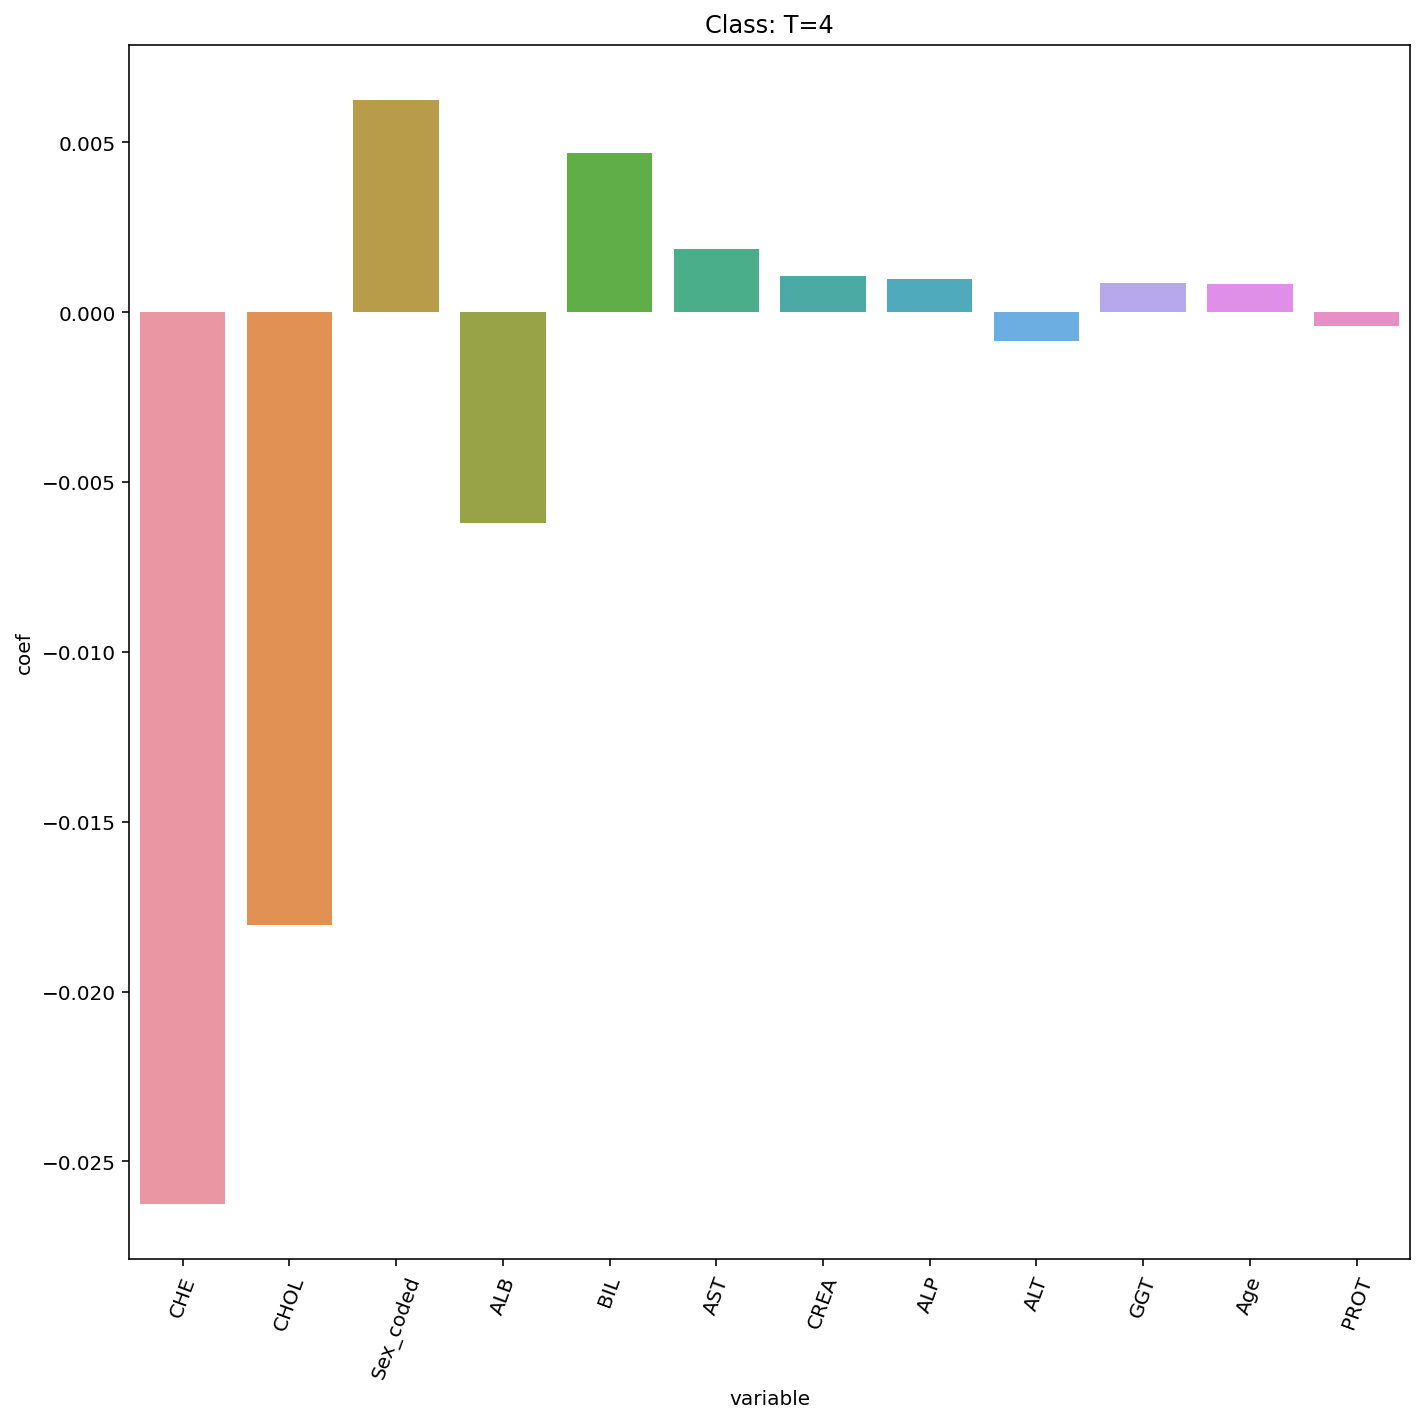

In [91]:
view_coeff(X_train, optimal_ridge)

In [93]:
logregcv = LogisticRegressionCV(multi_class='ovr',solver='liblinear', cv=4)
logregcv.fit(X_train, y_train)

LogisticRegressionCV(cv=4, multi_class='ovr', solver='liblinear')

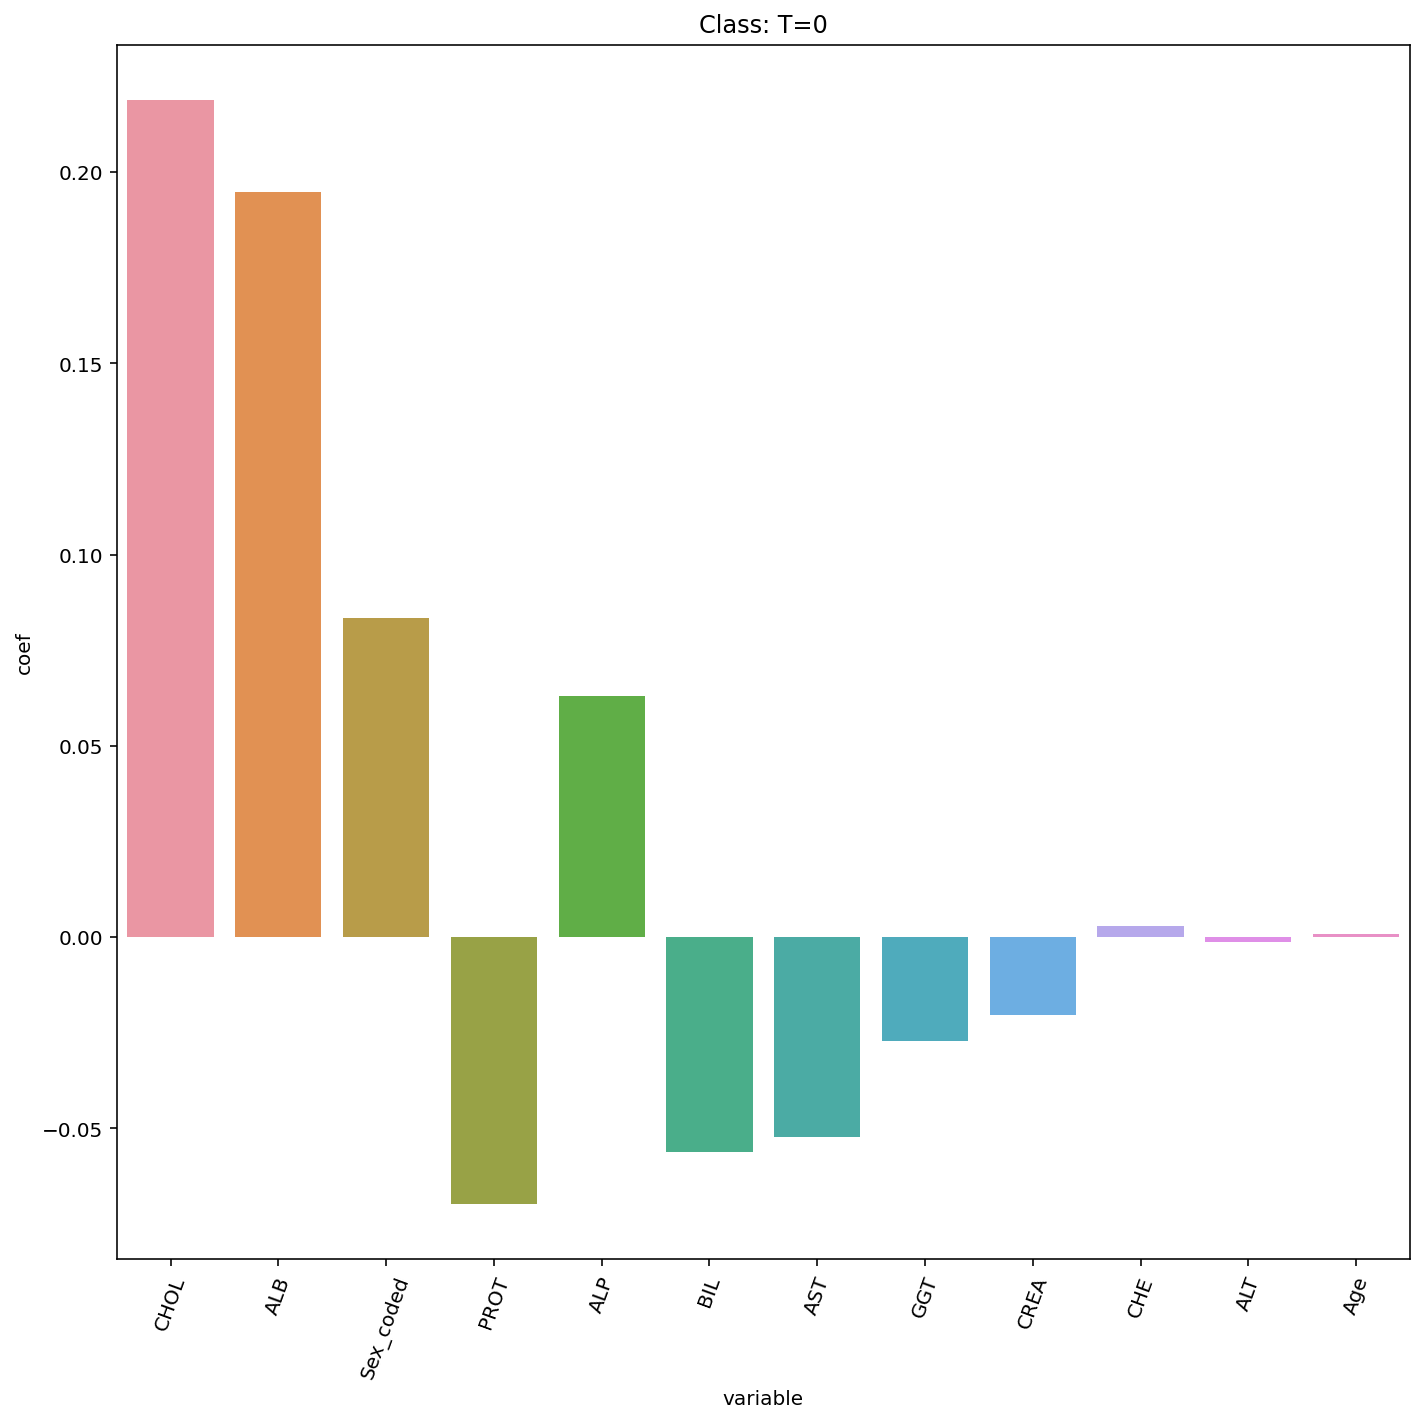

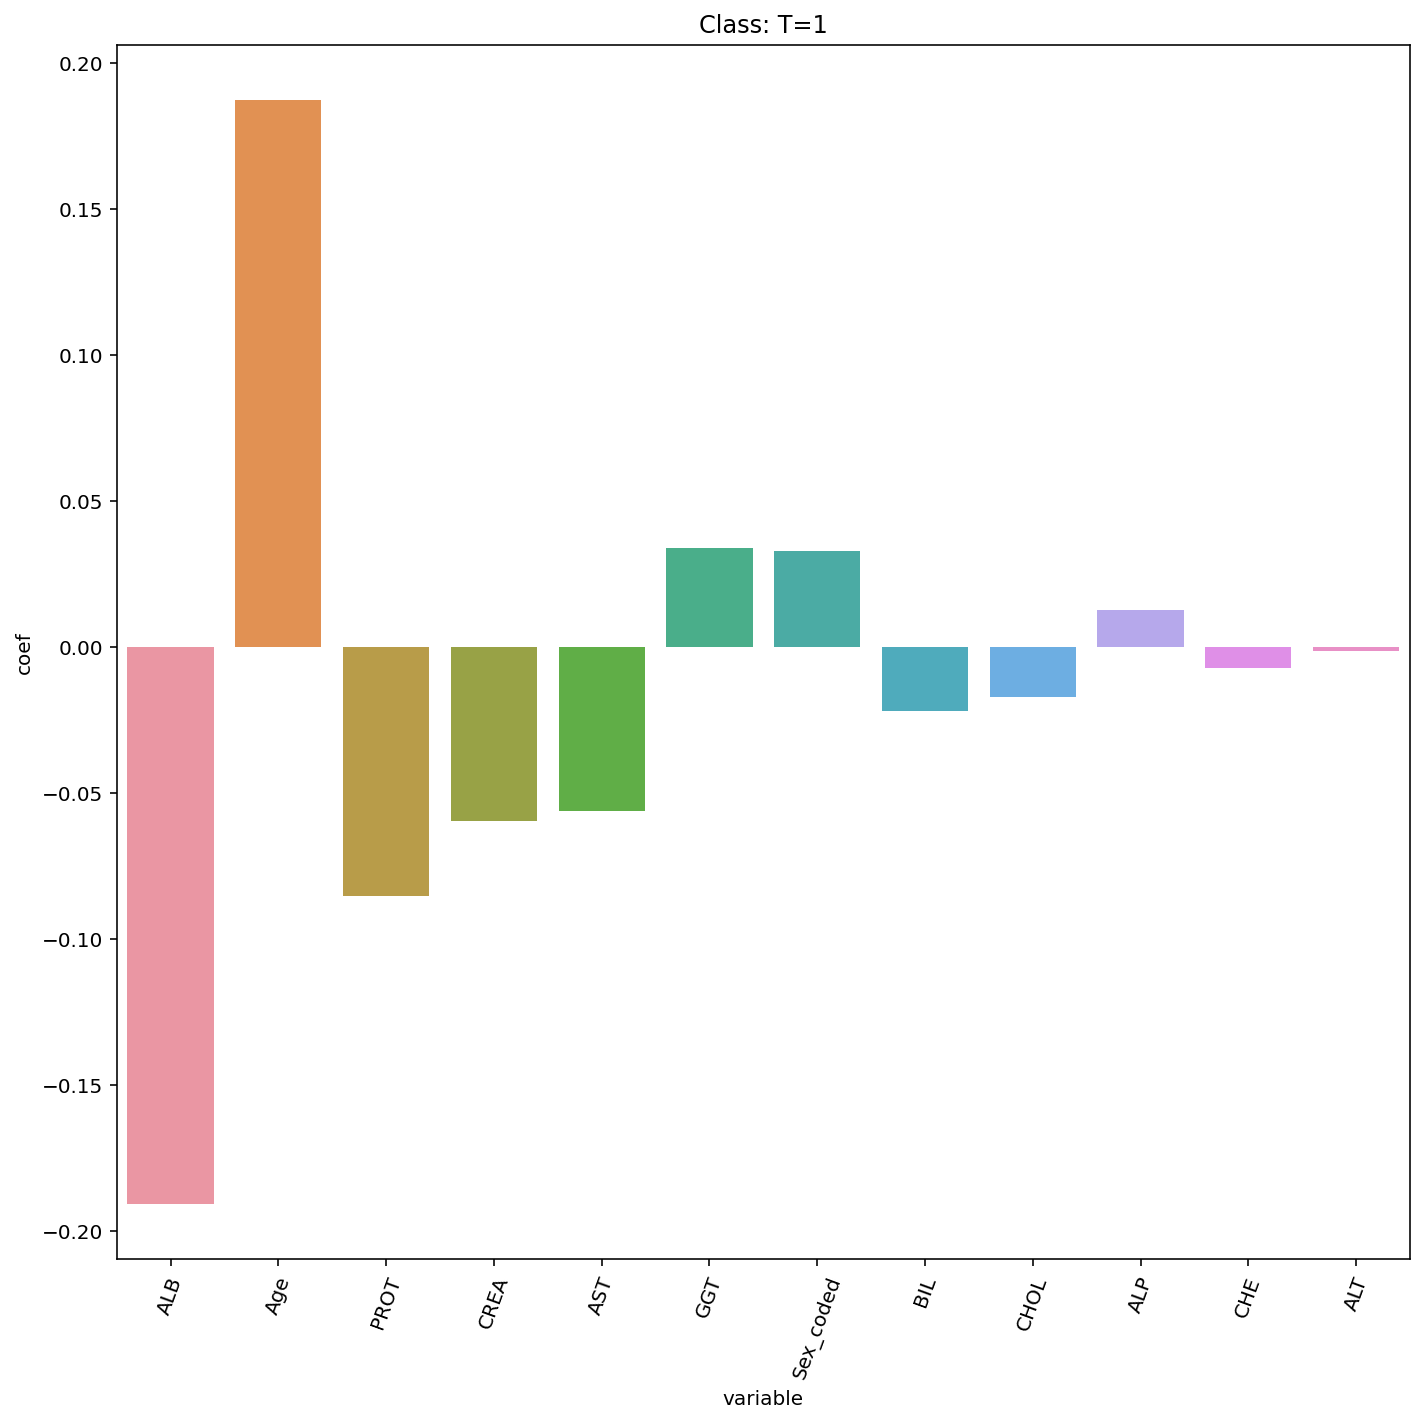

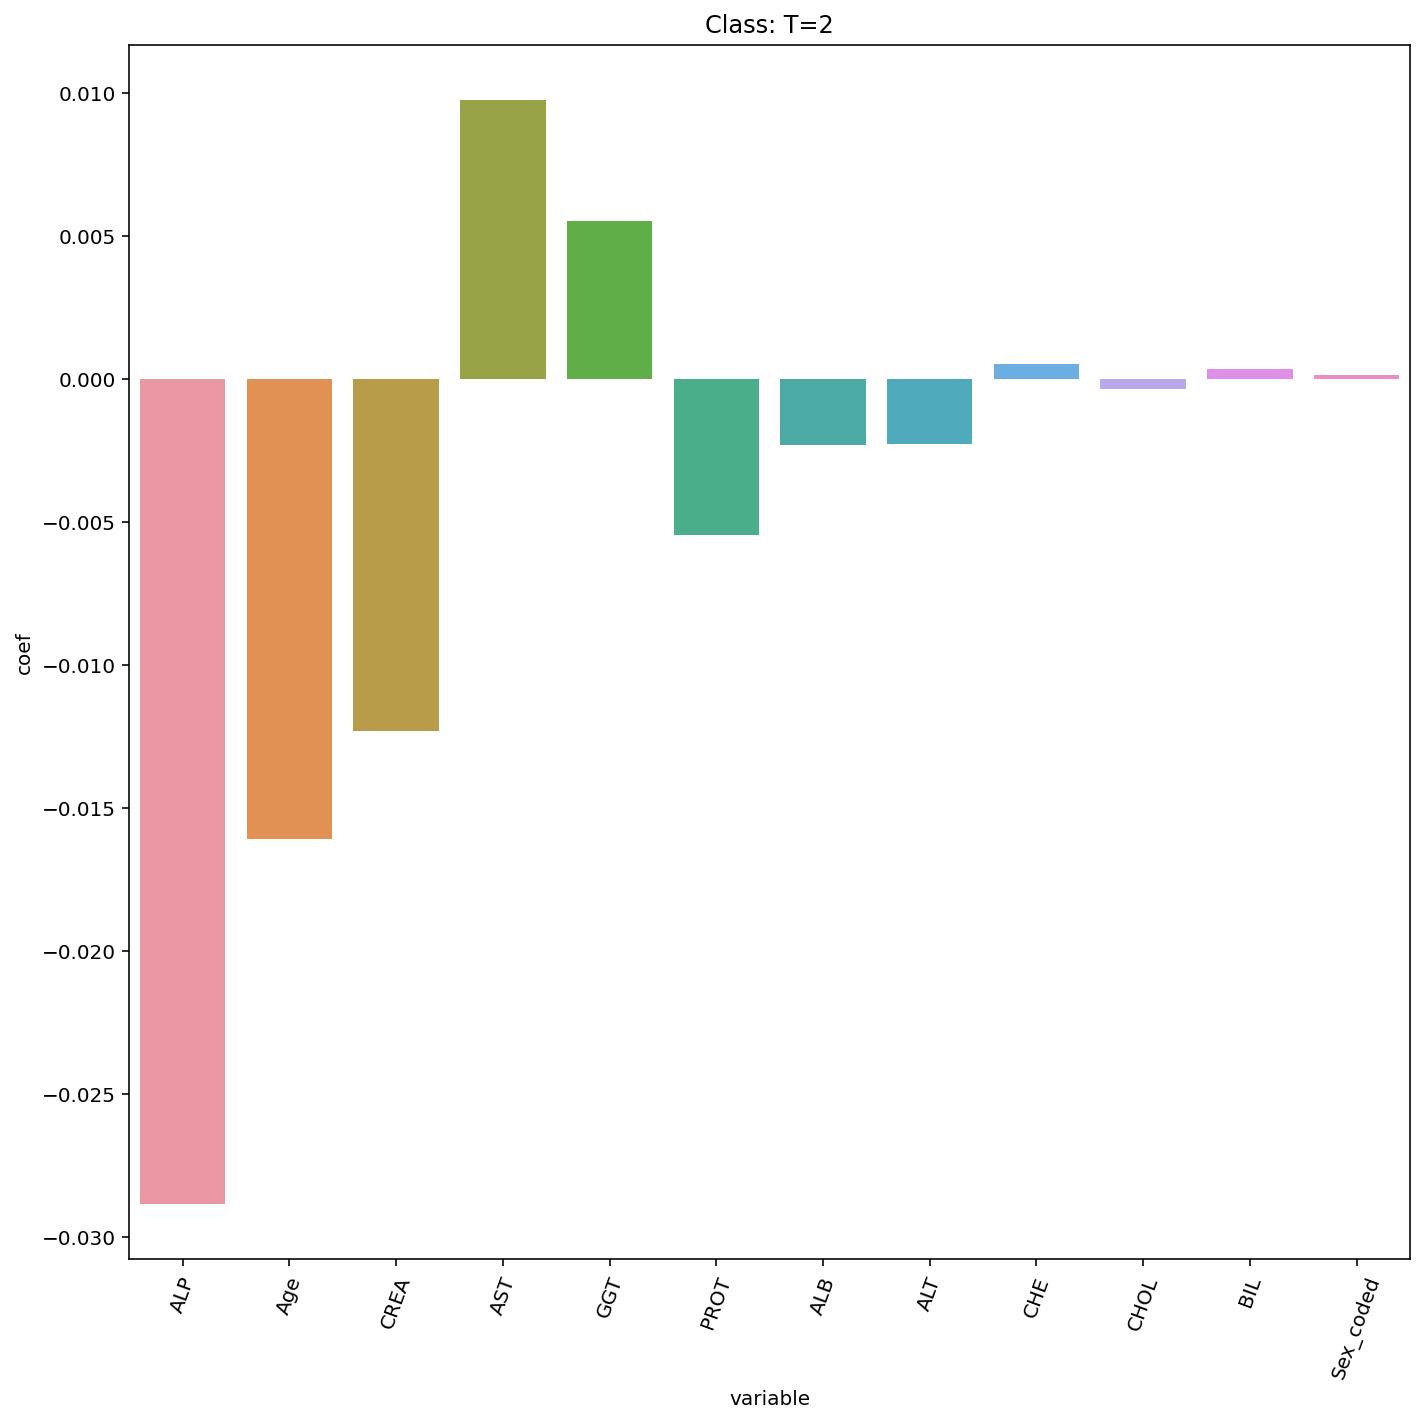

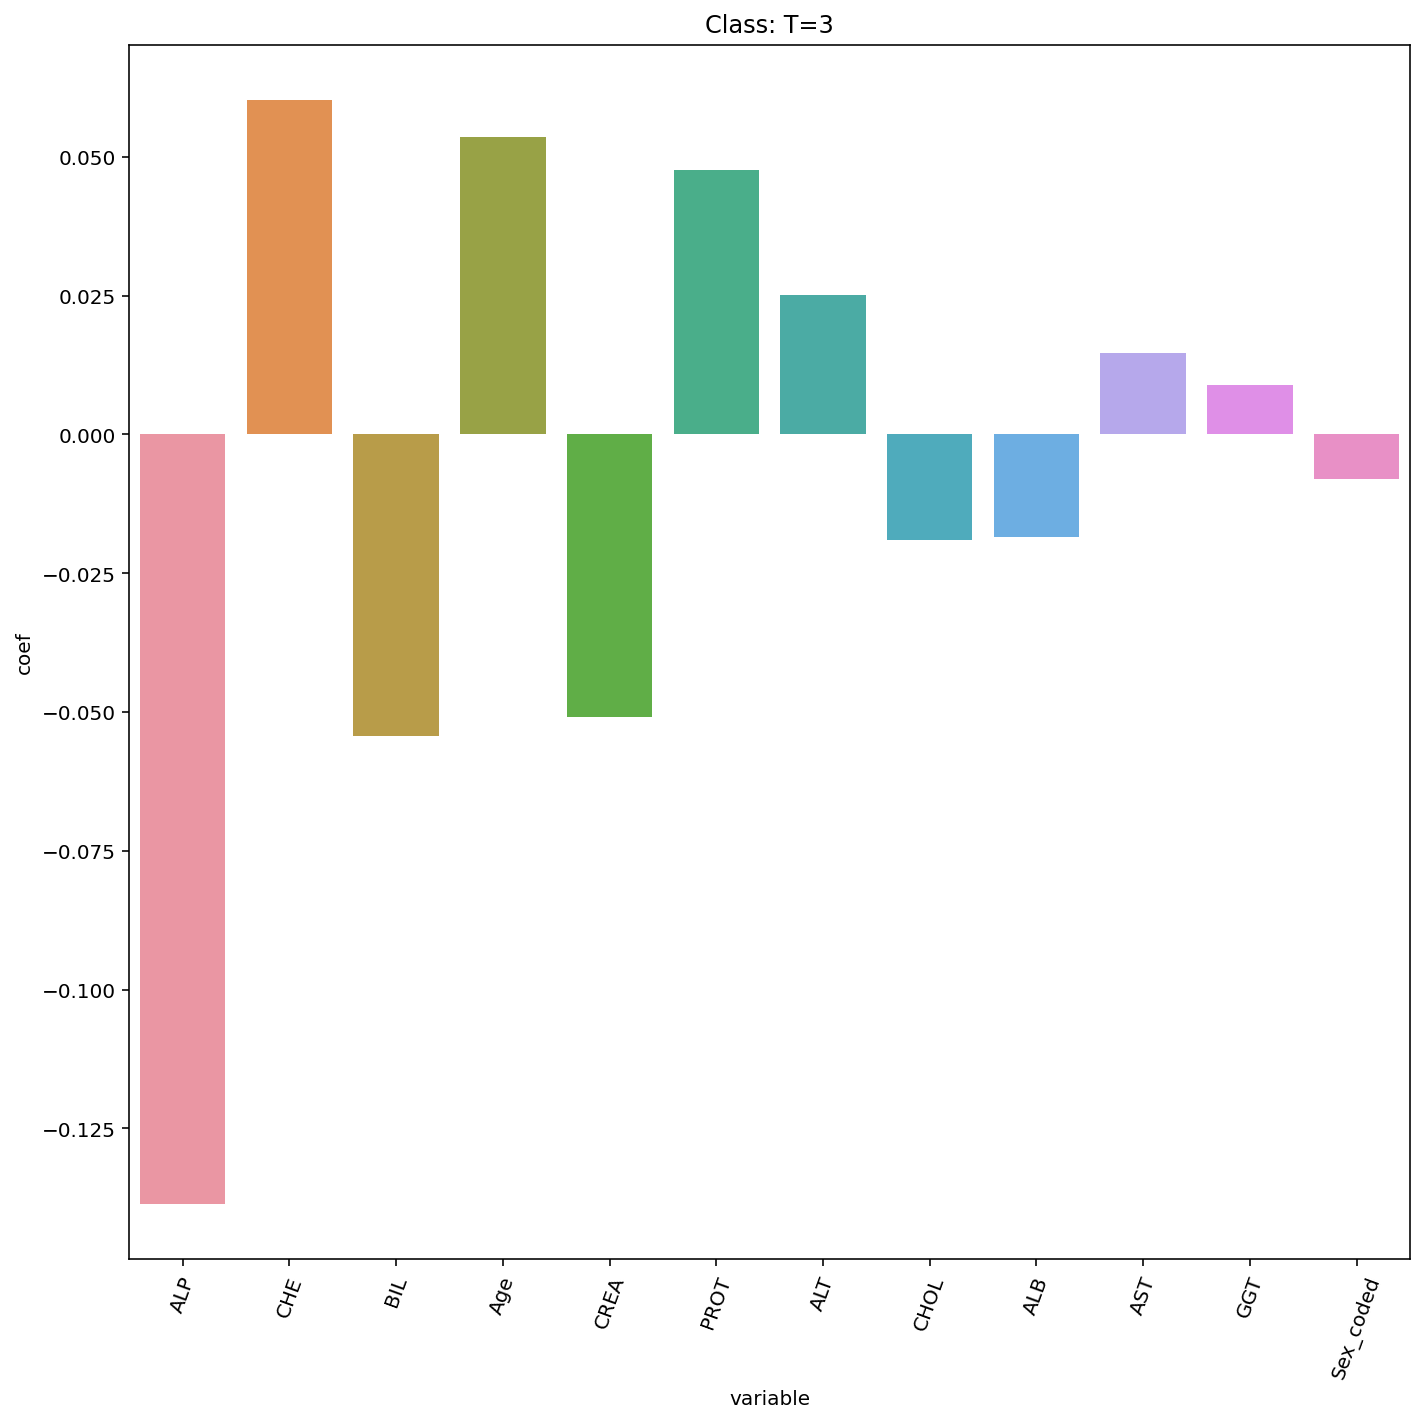

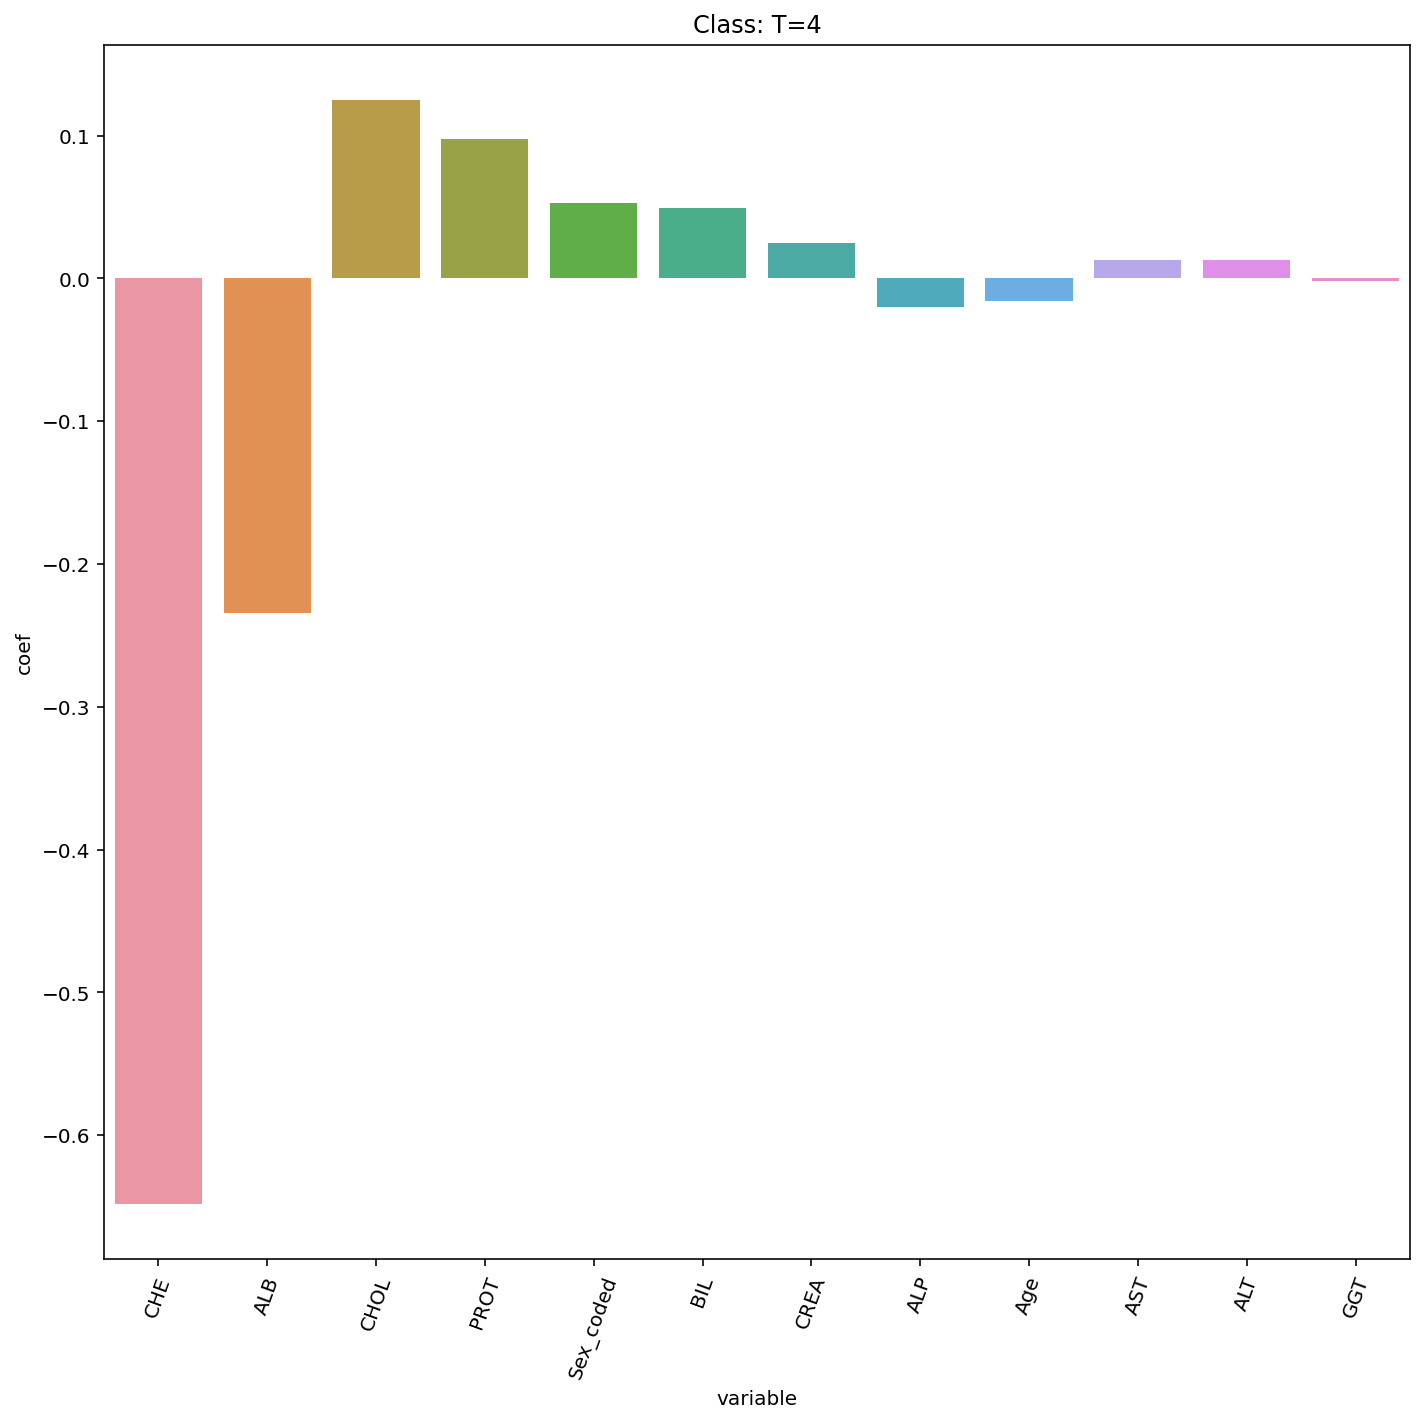

In [94]:
view_coeff(X, logregcv)

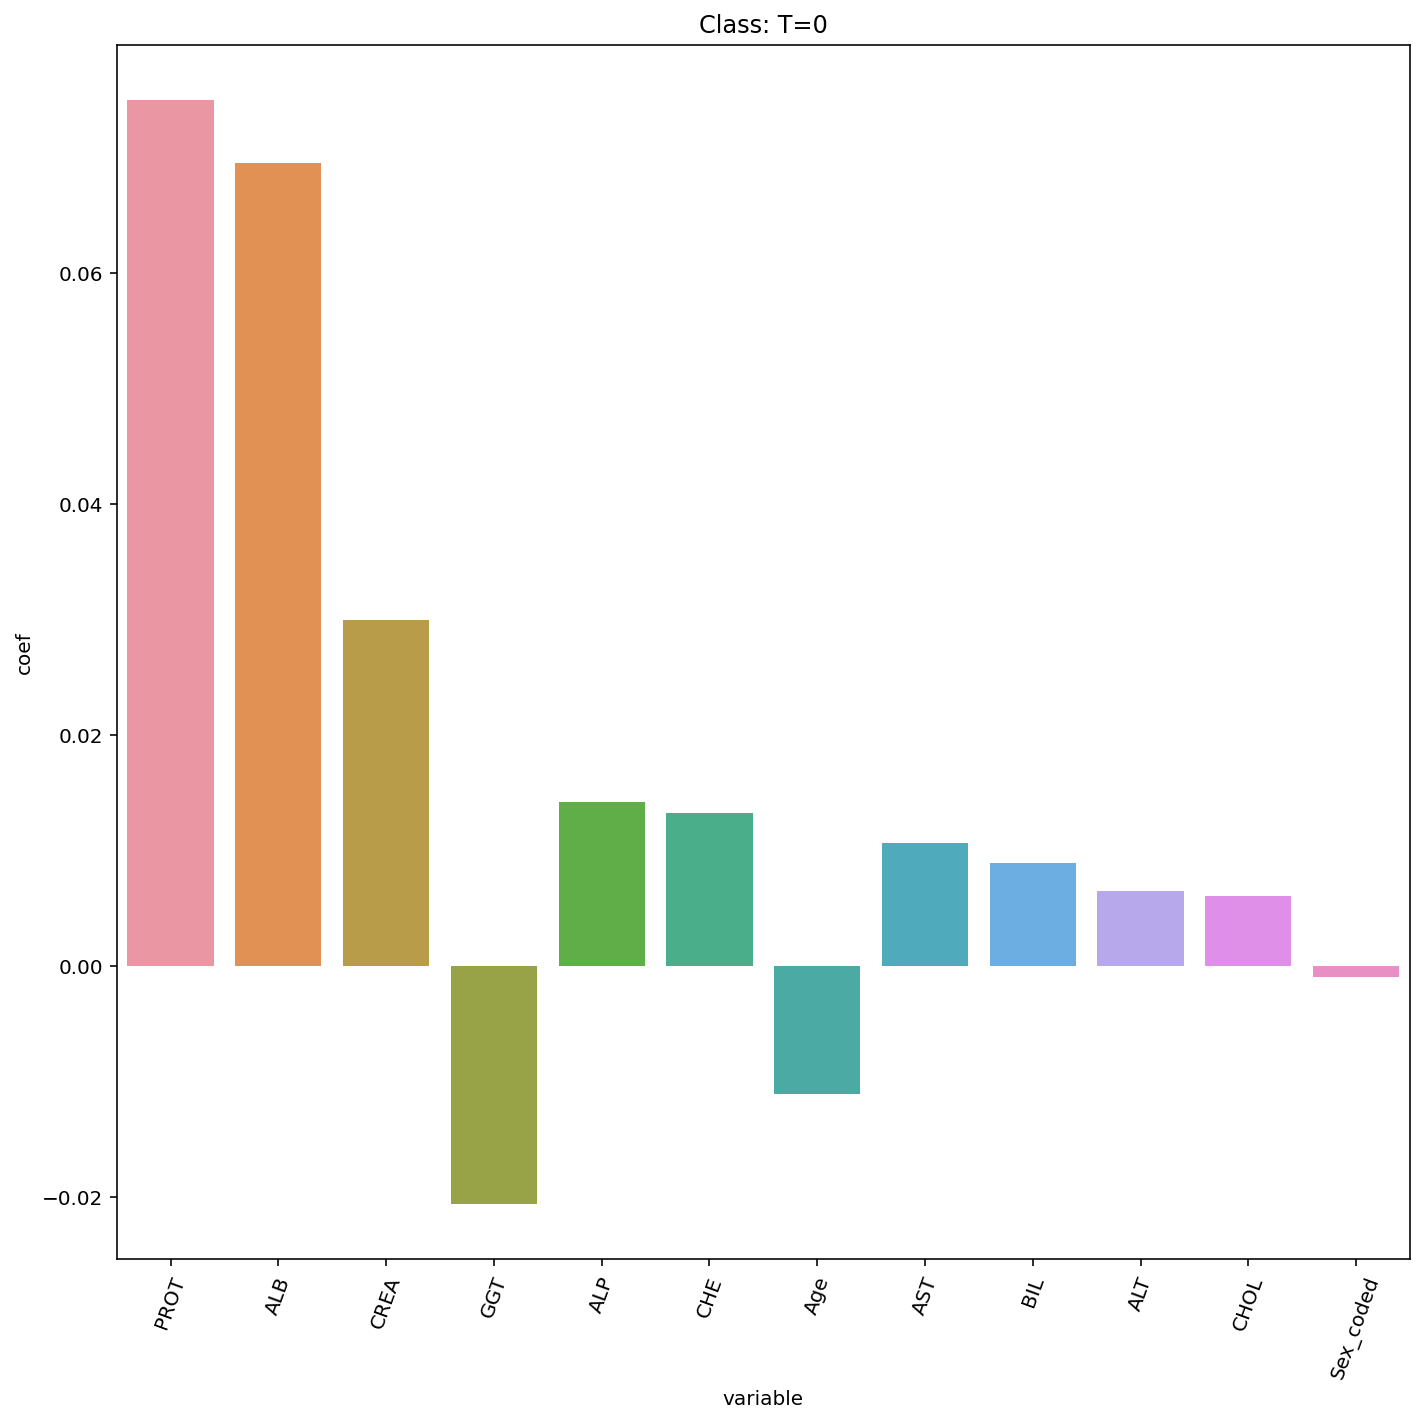

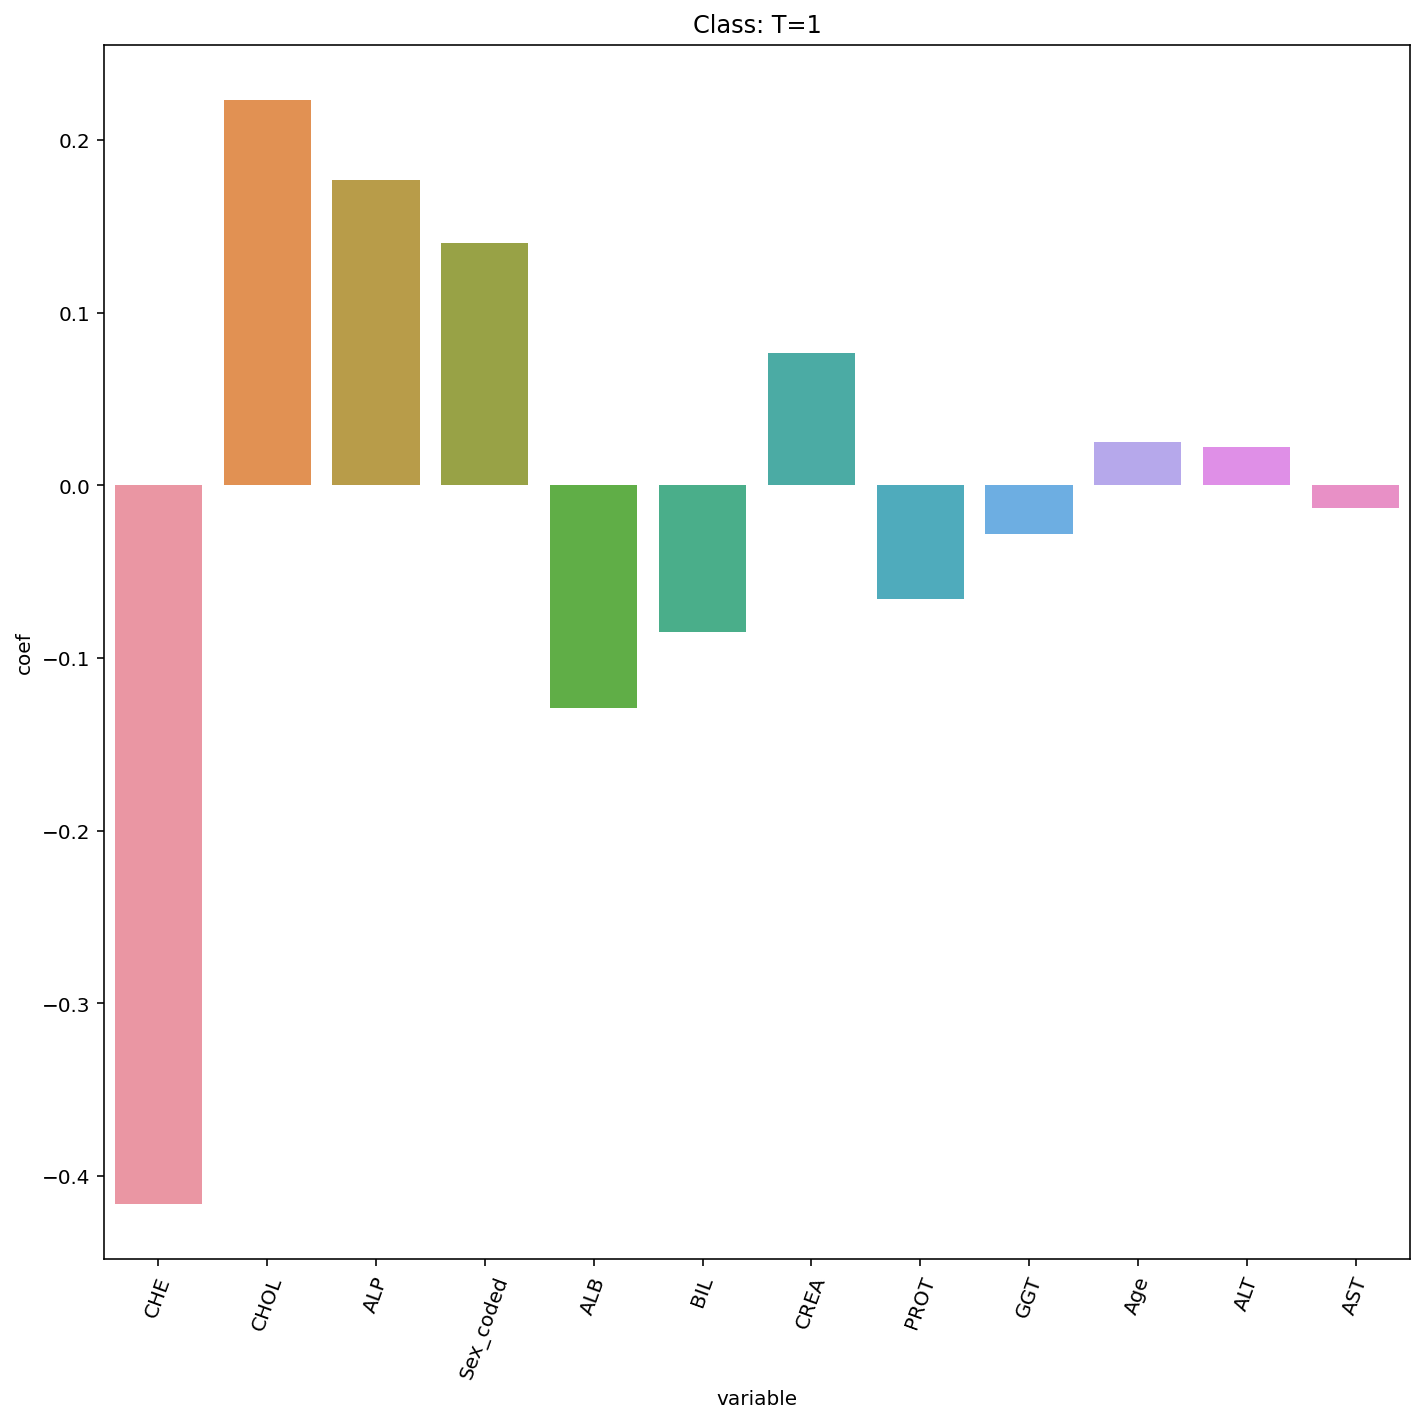

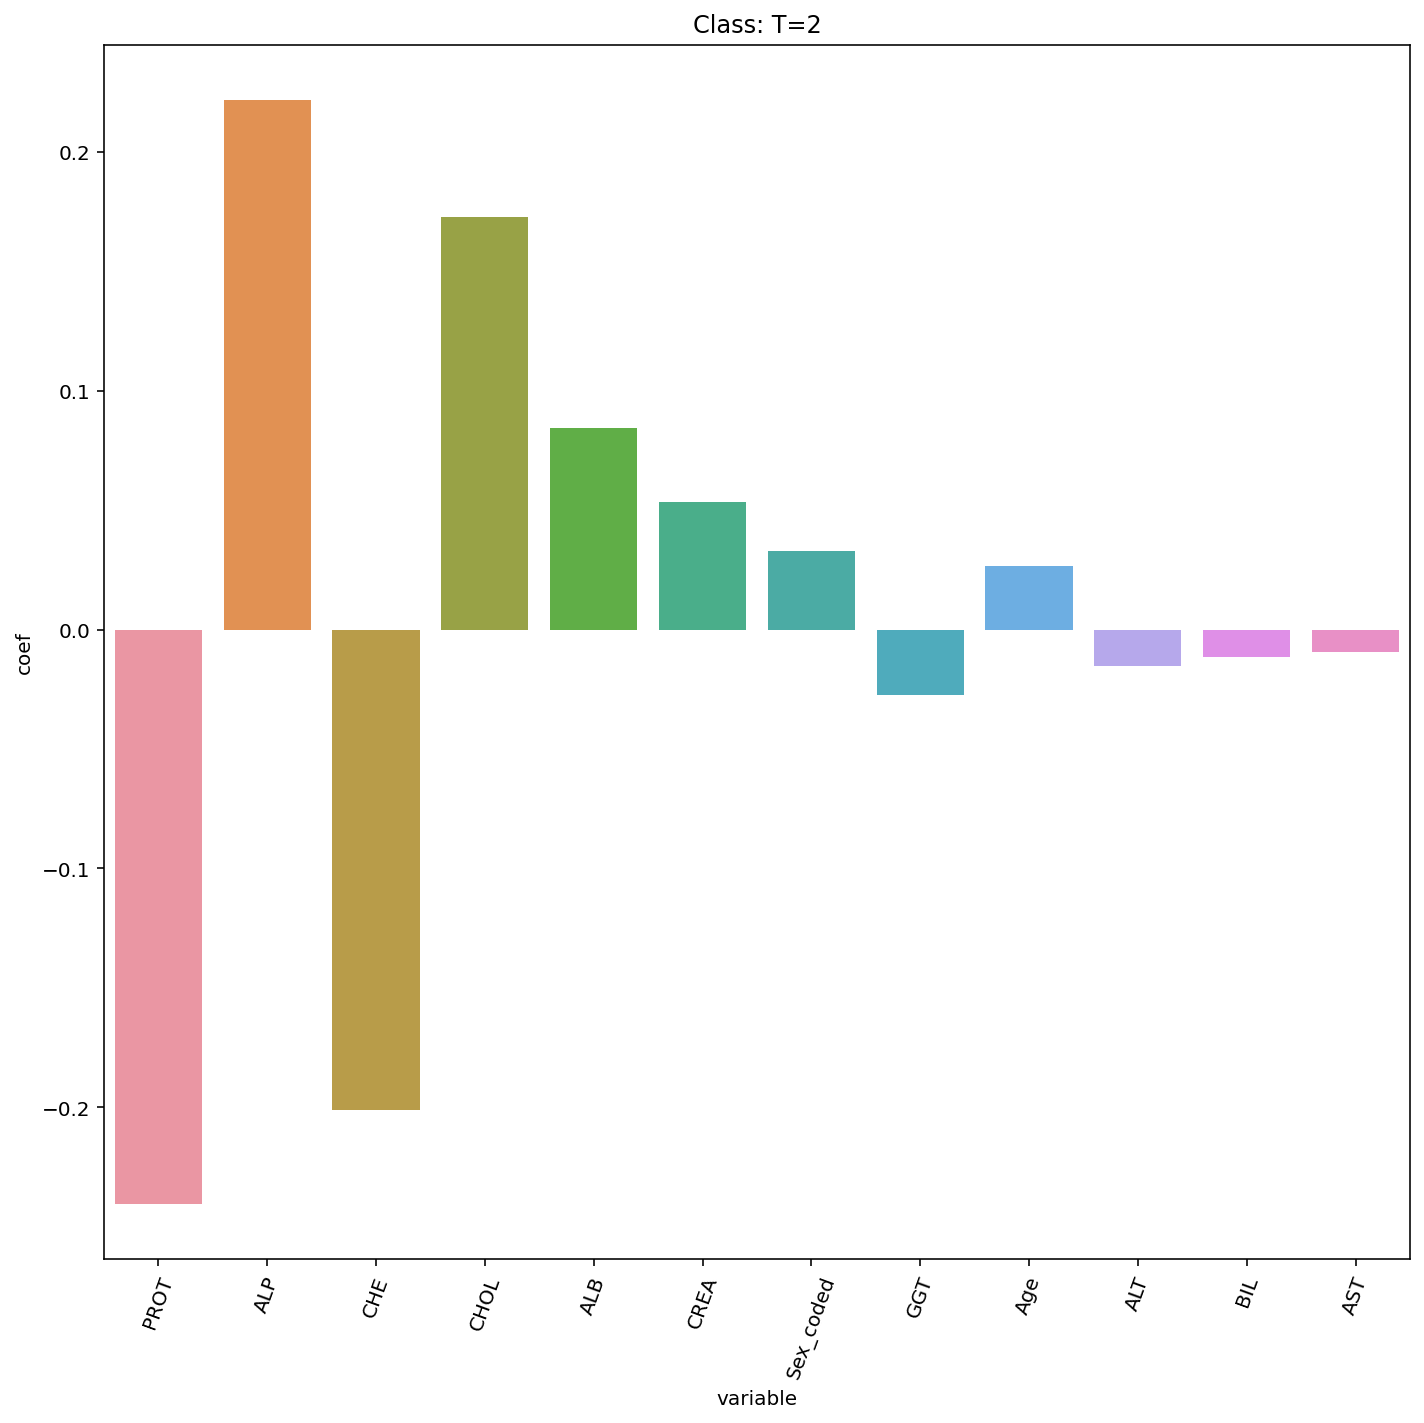

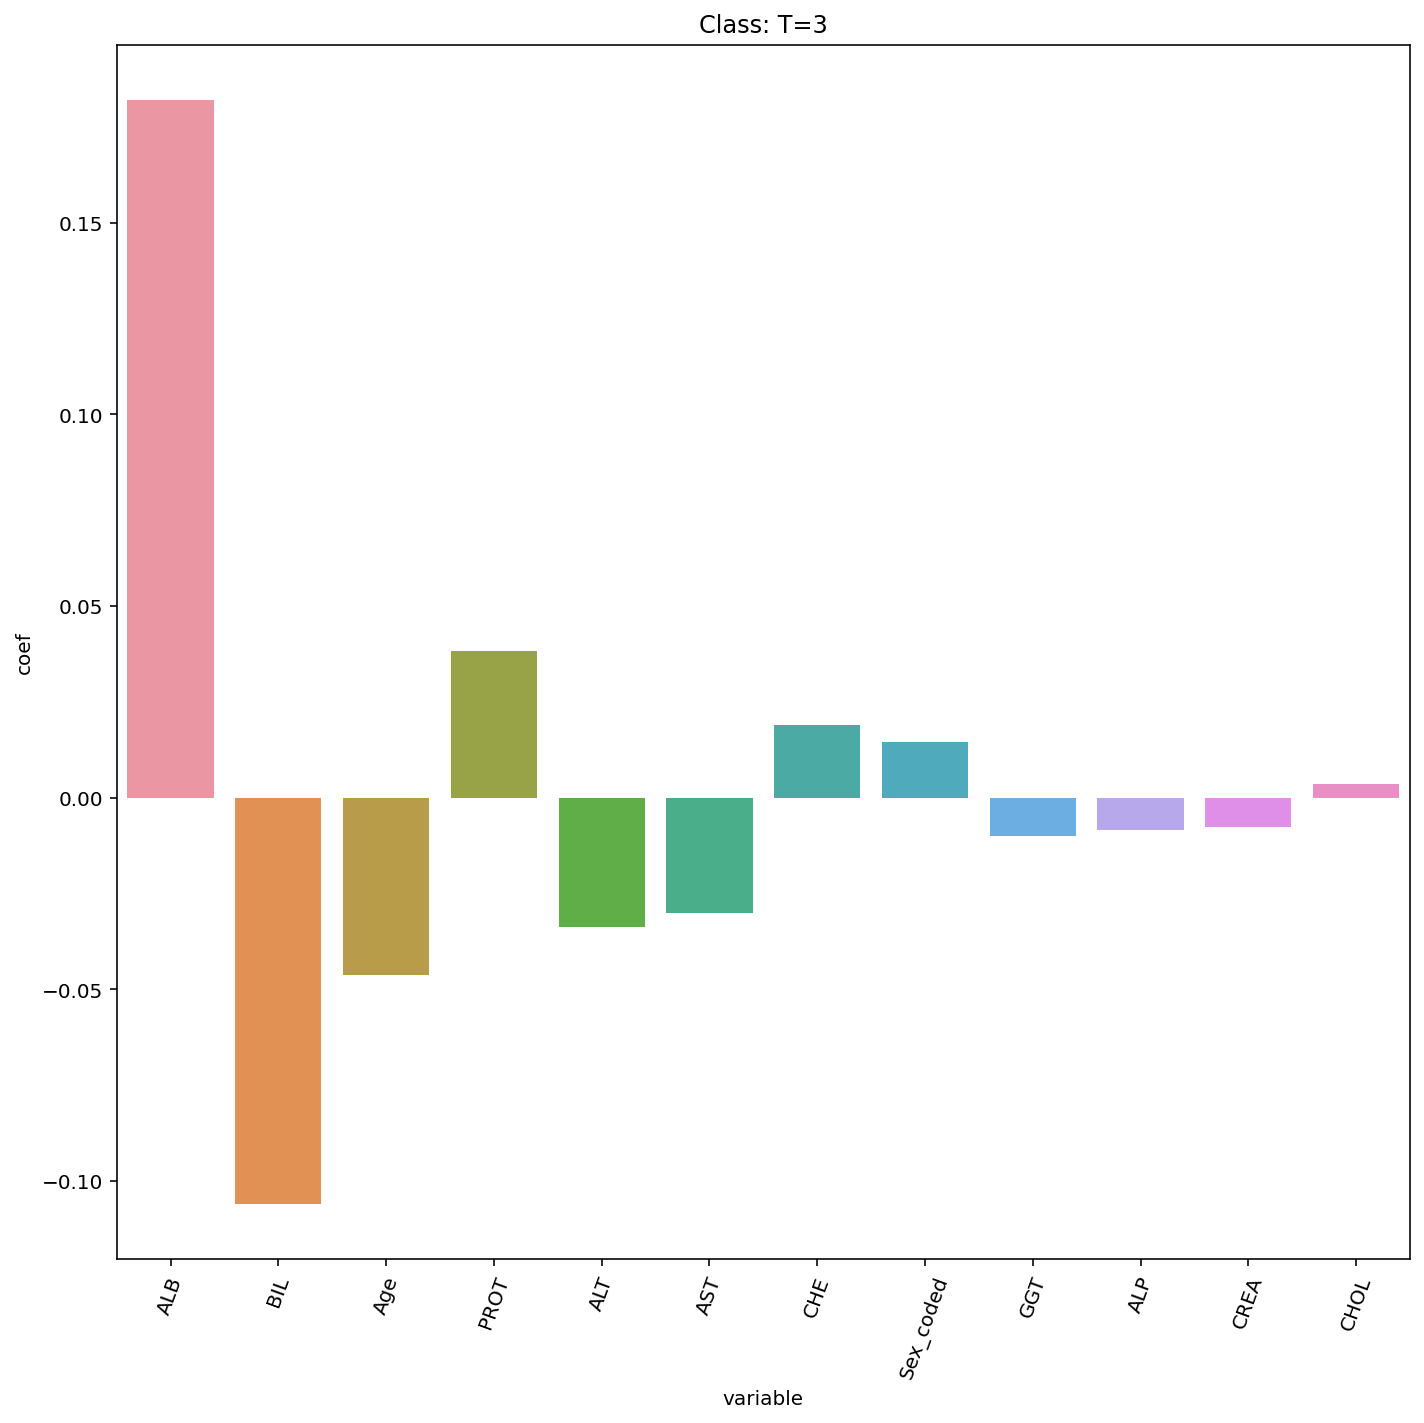

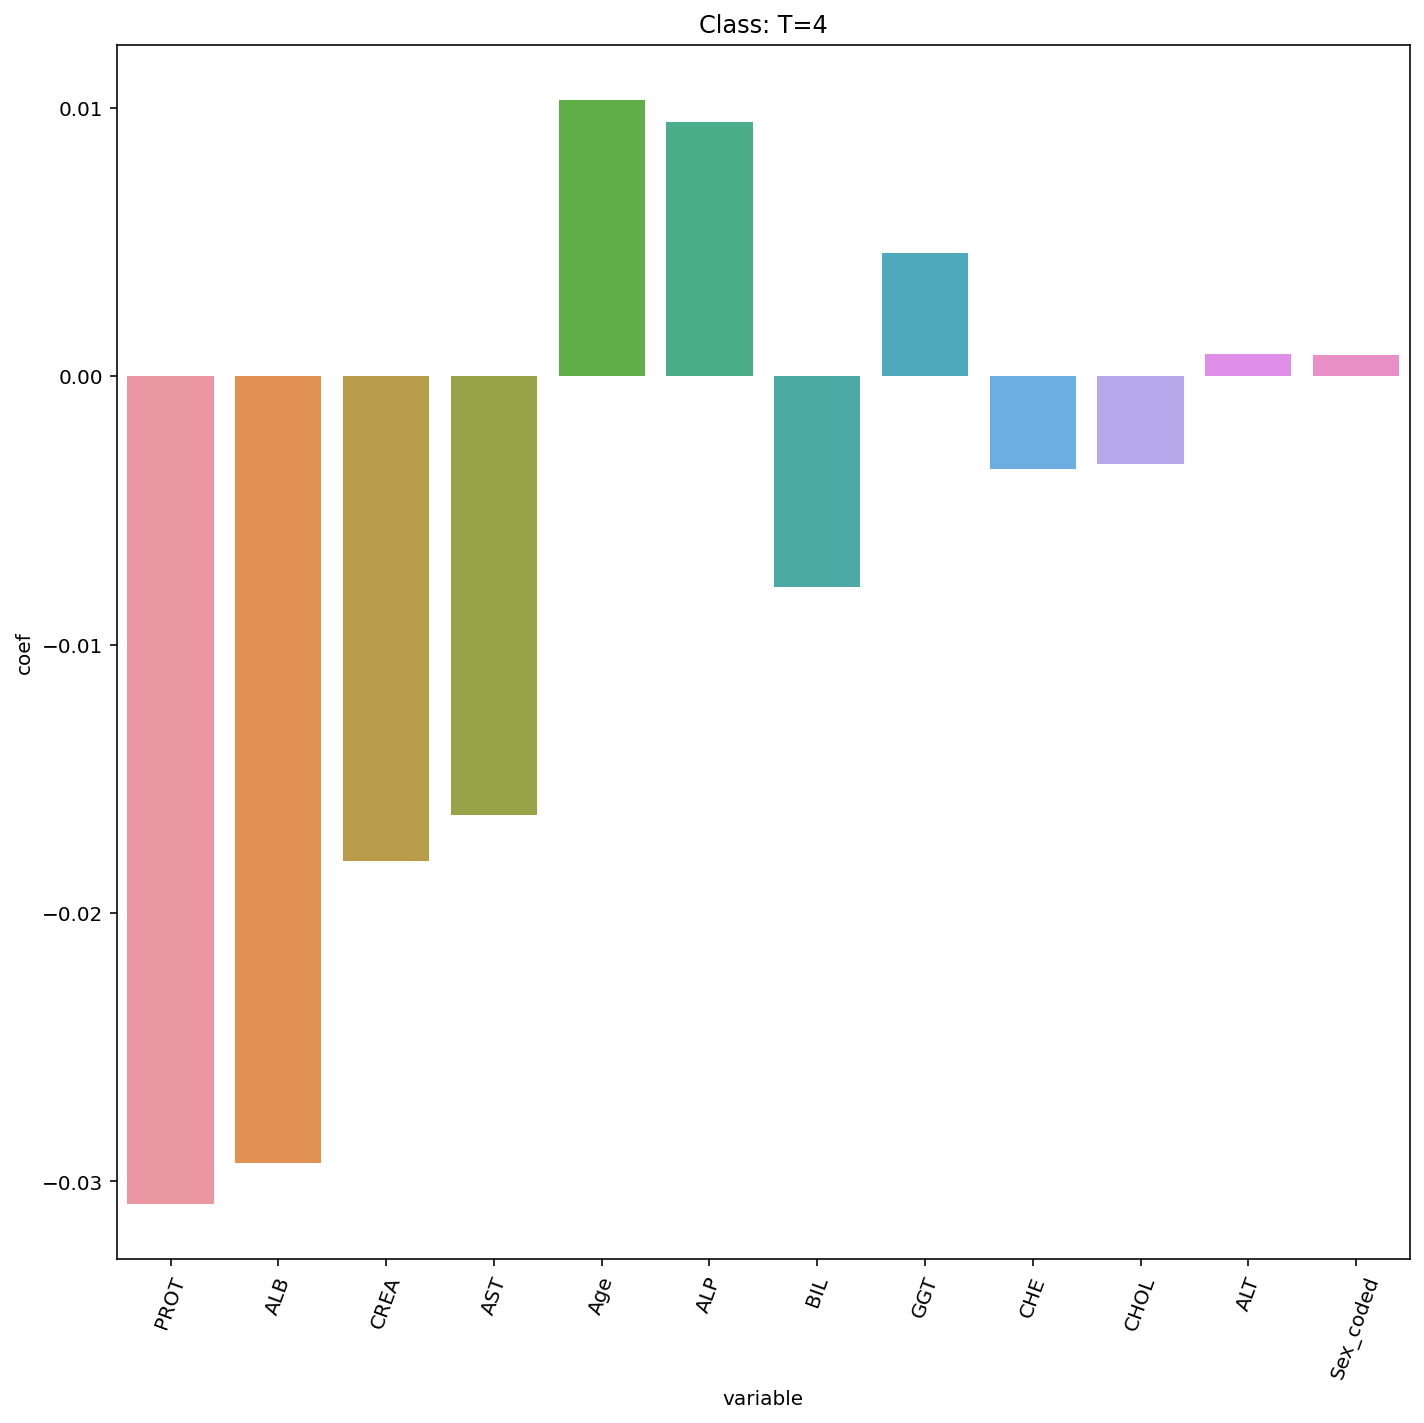

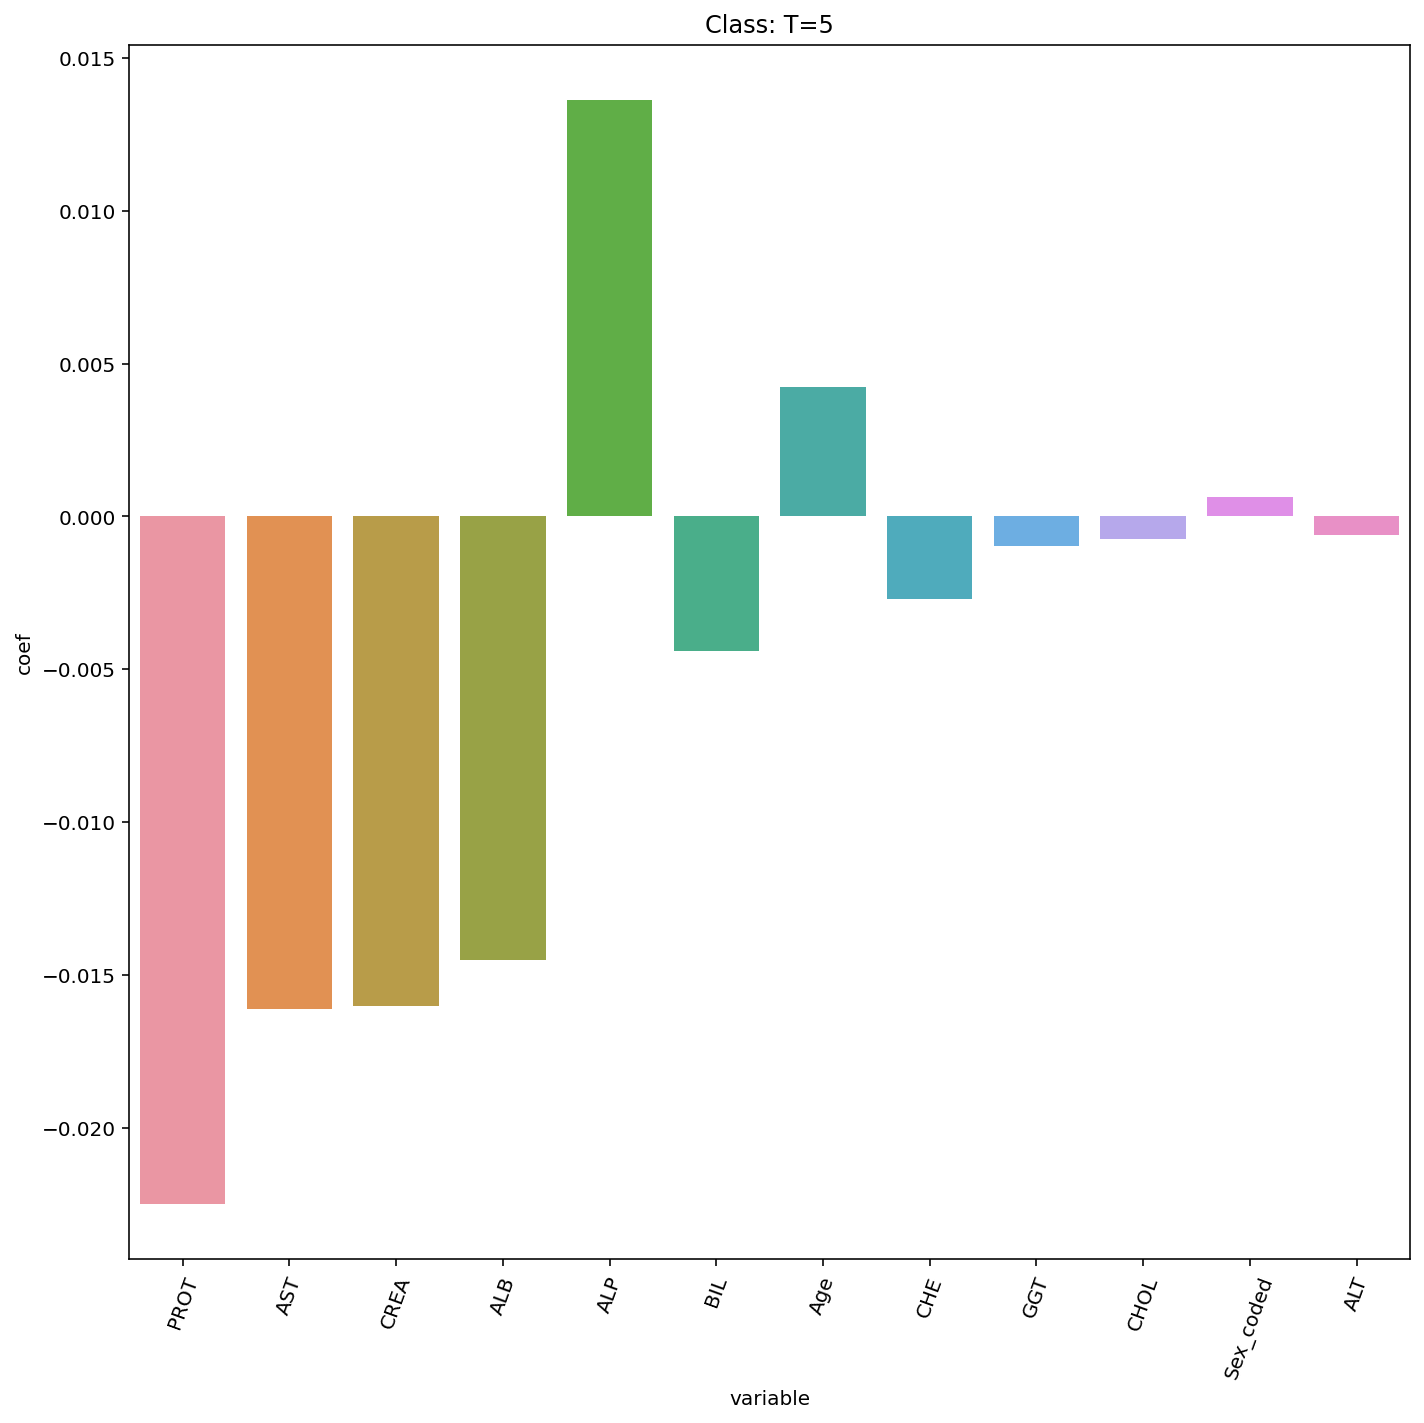

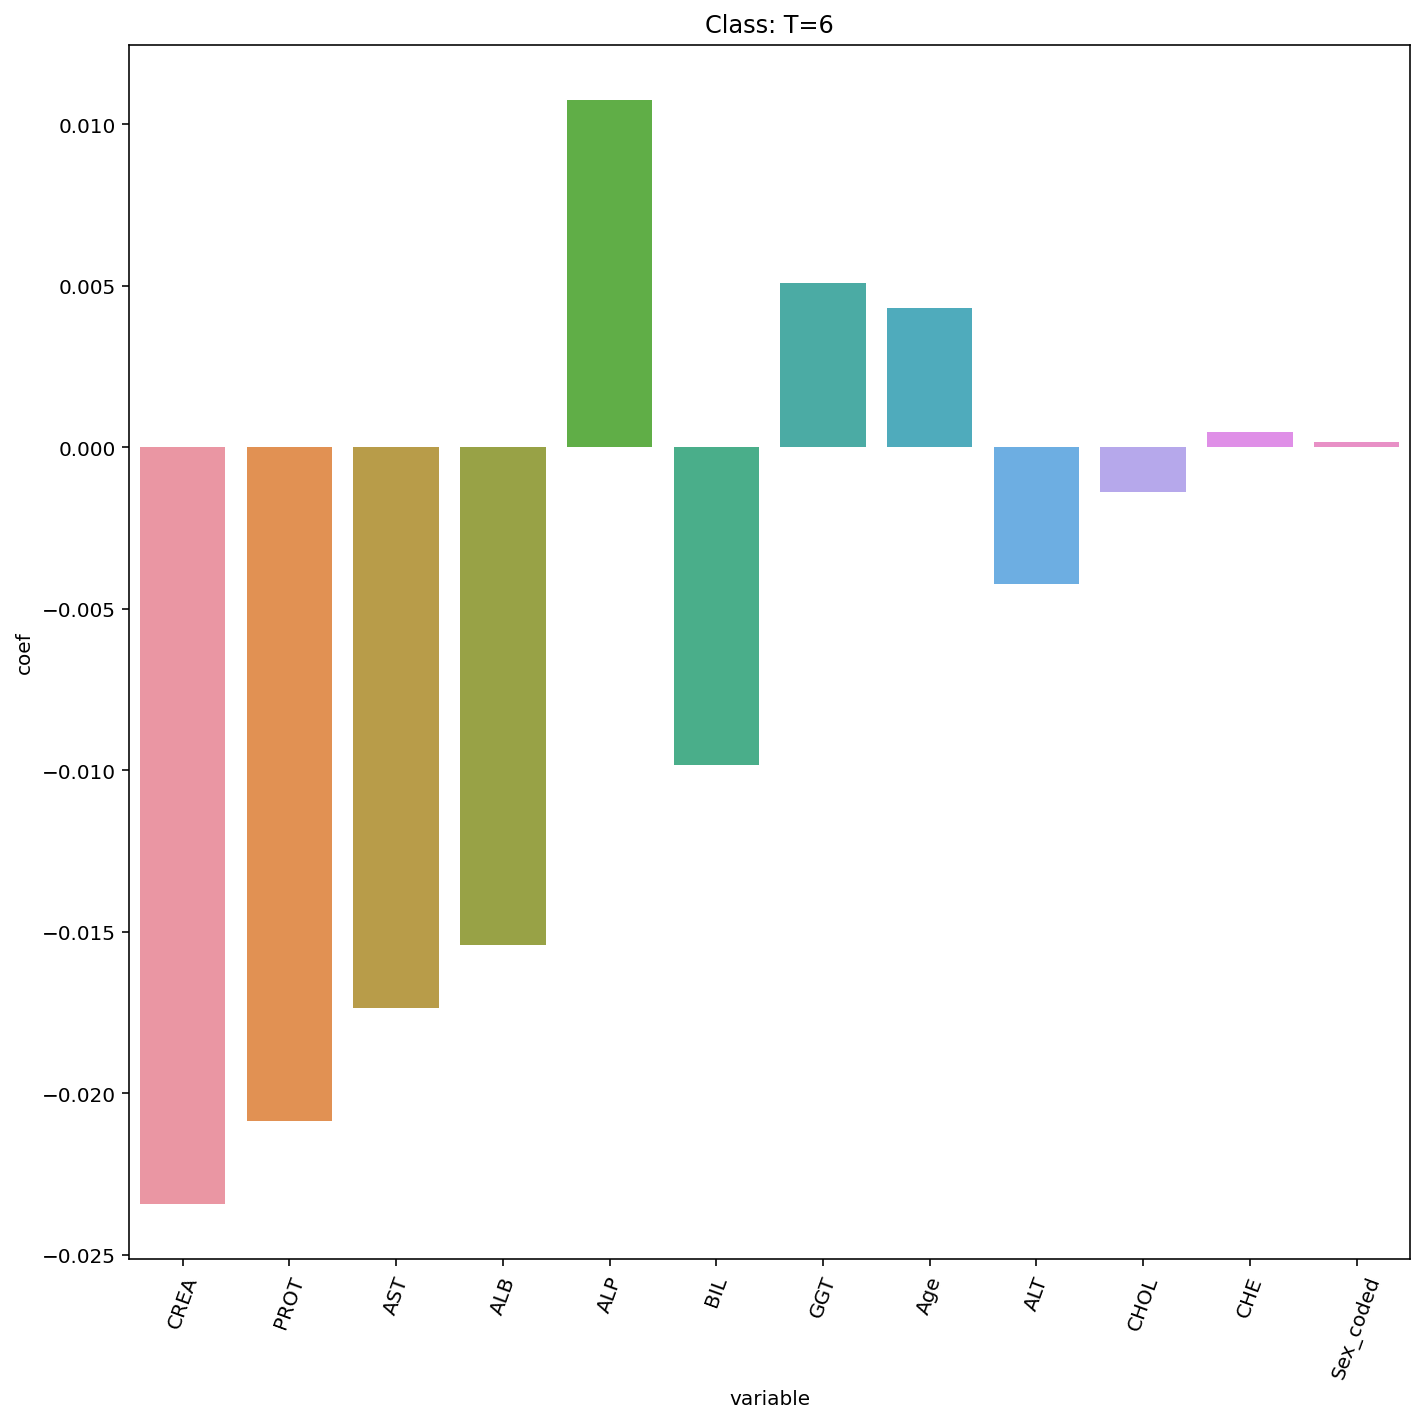

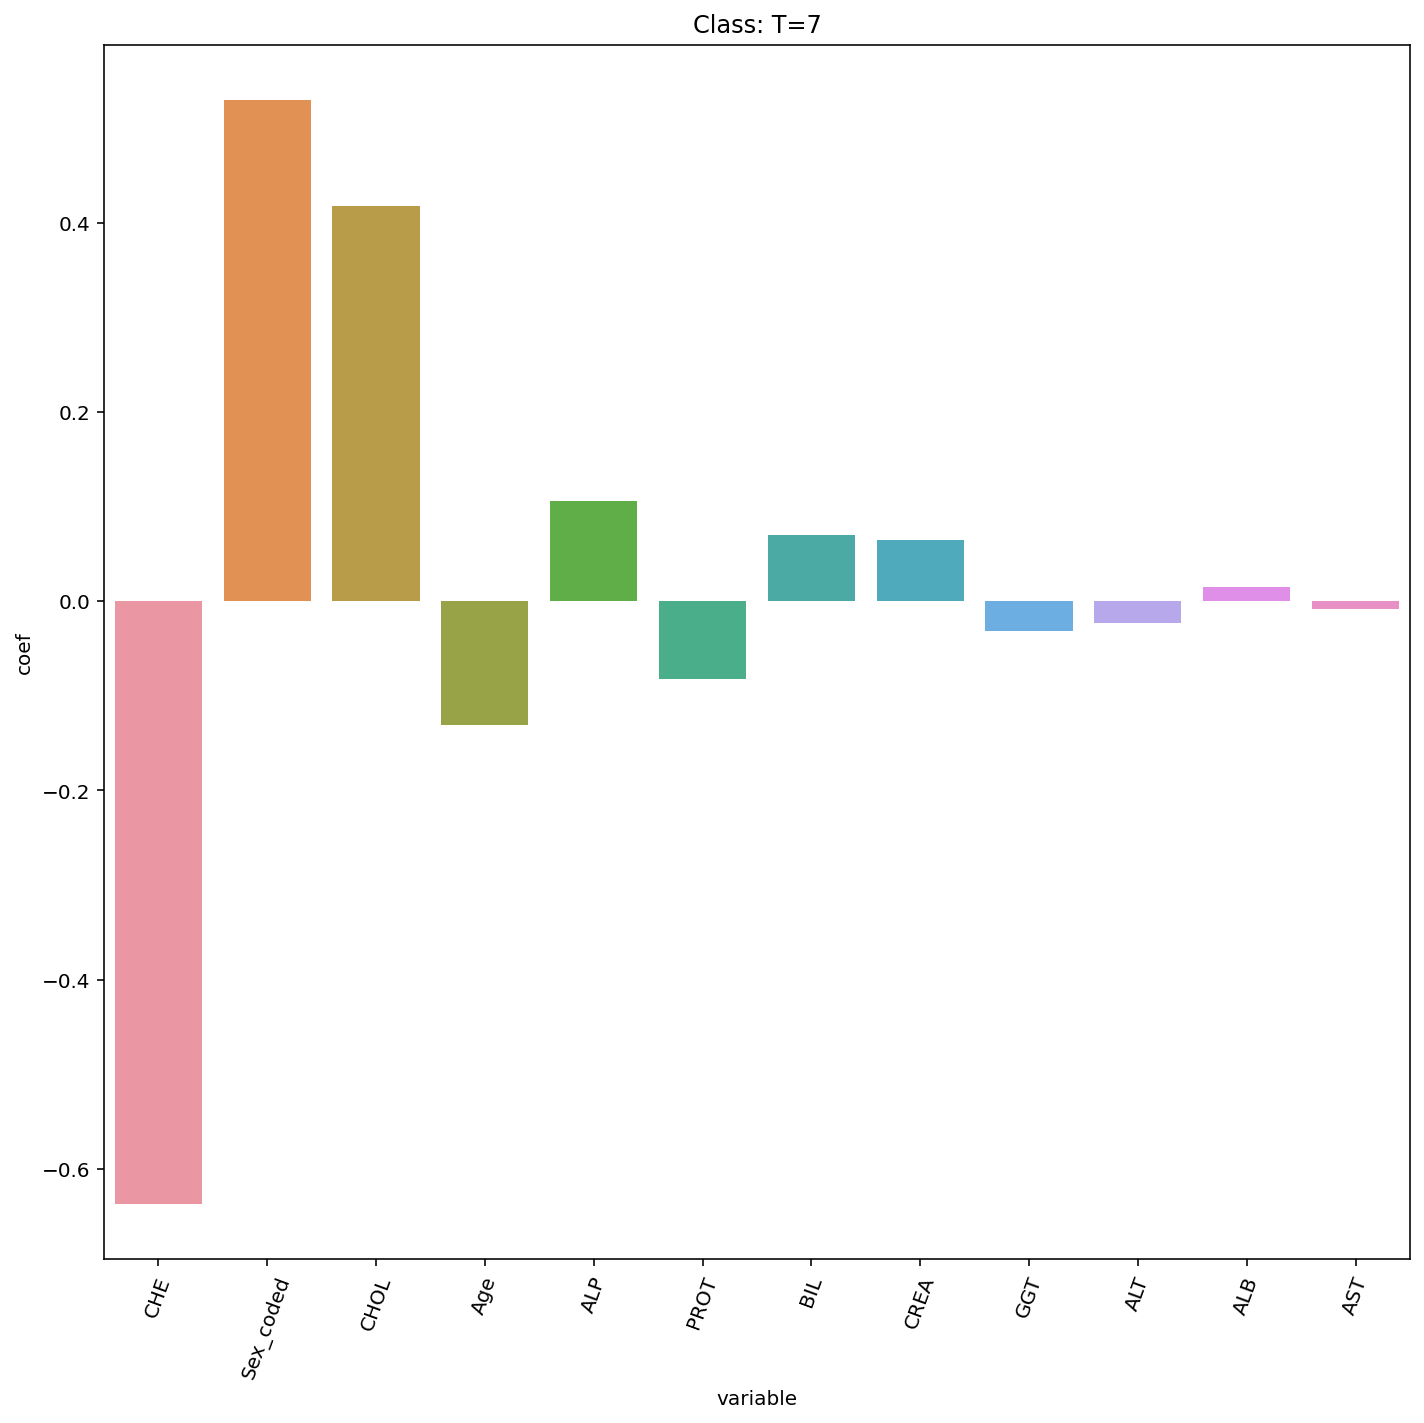

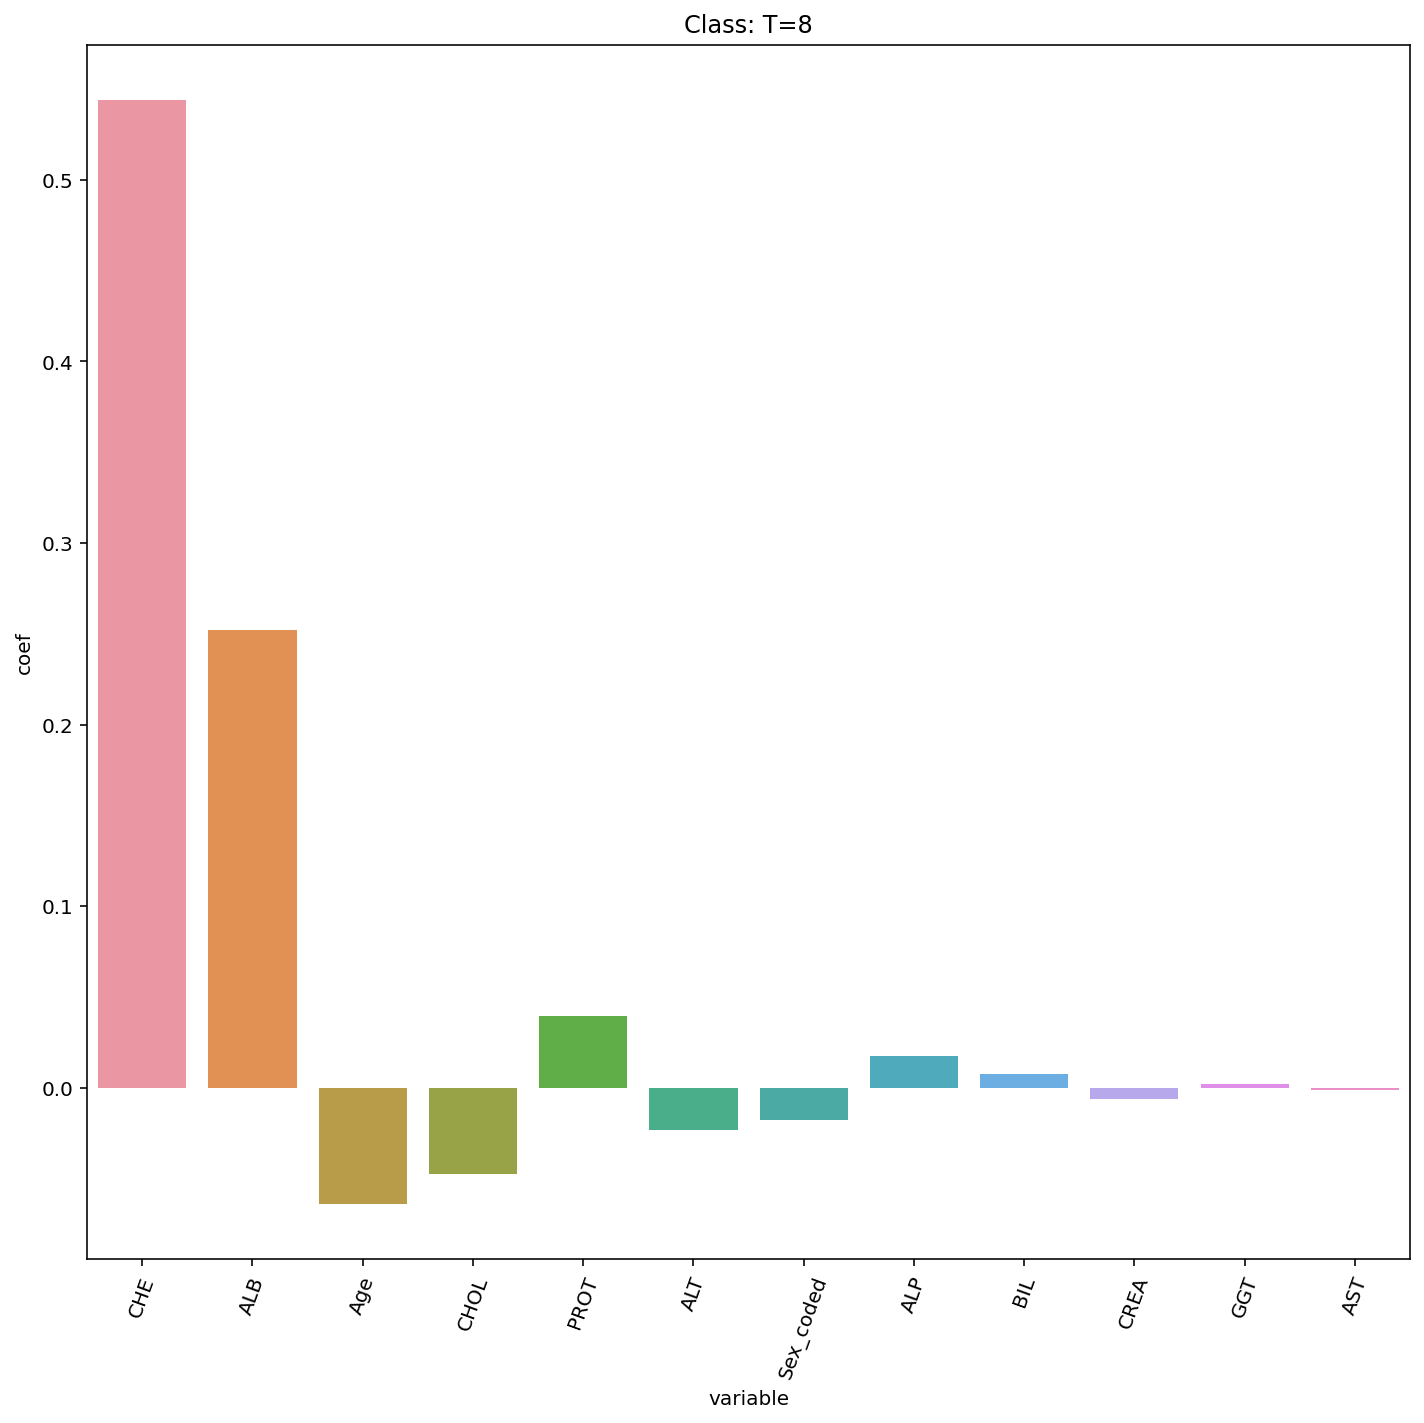

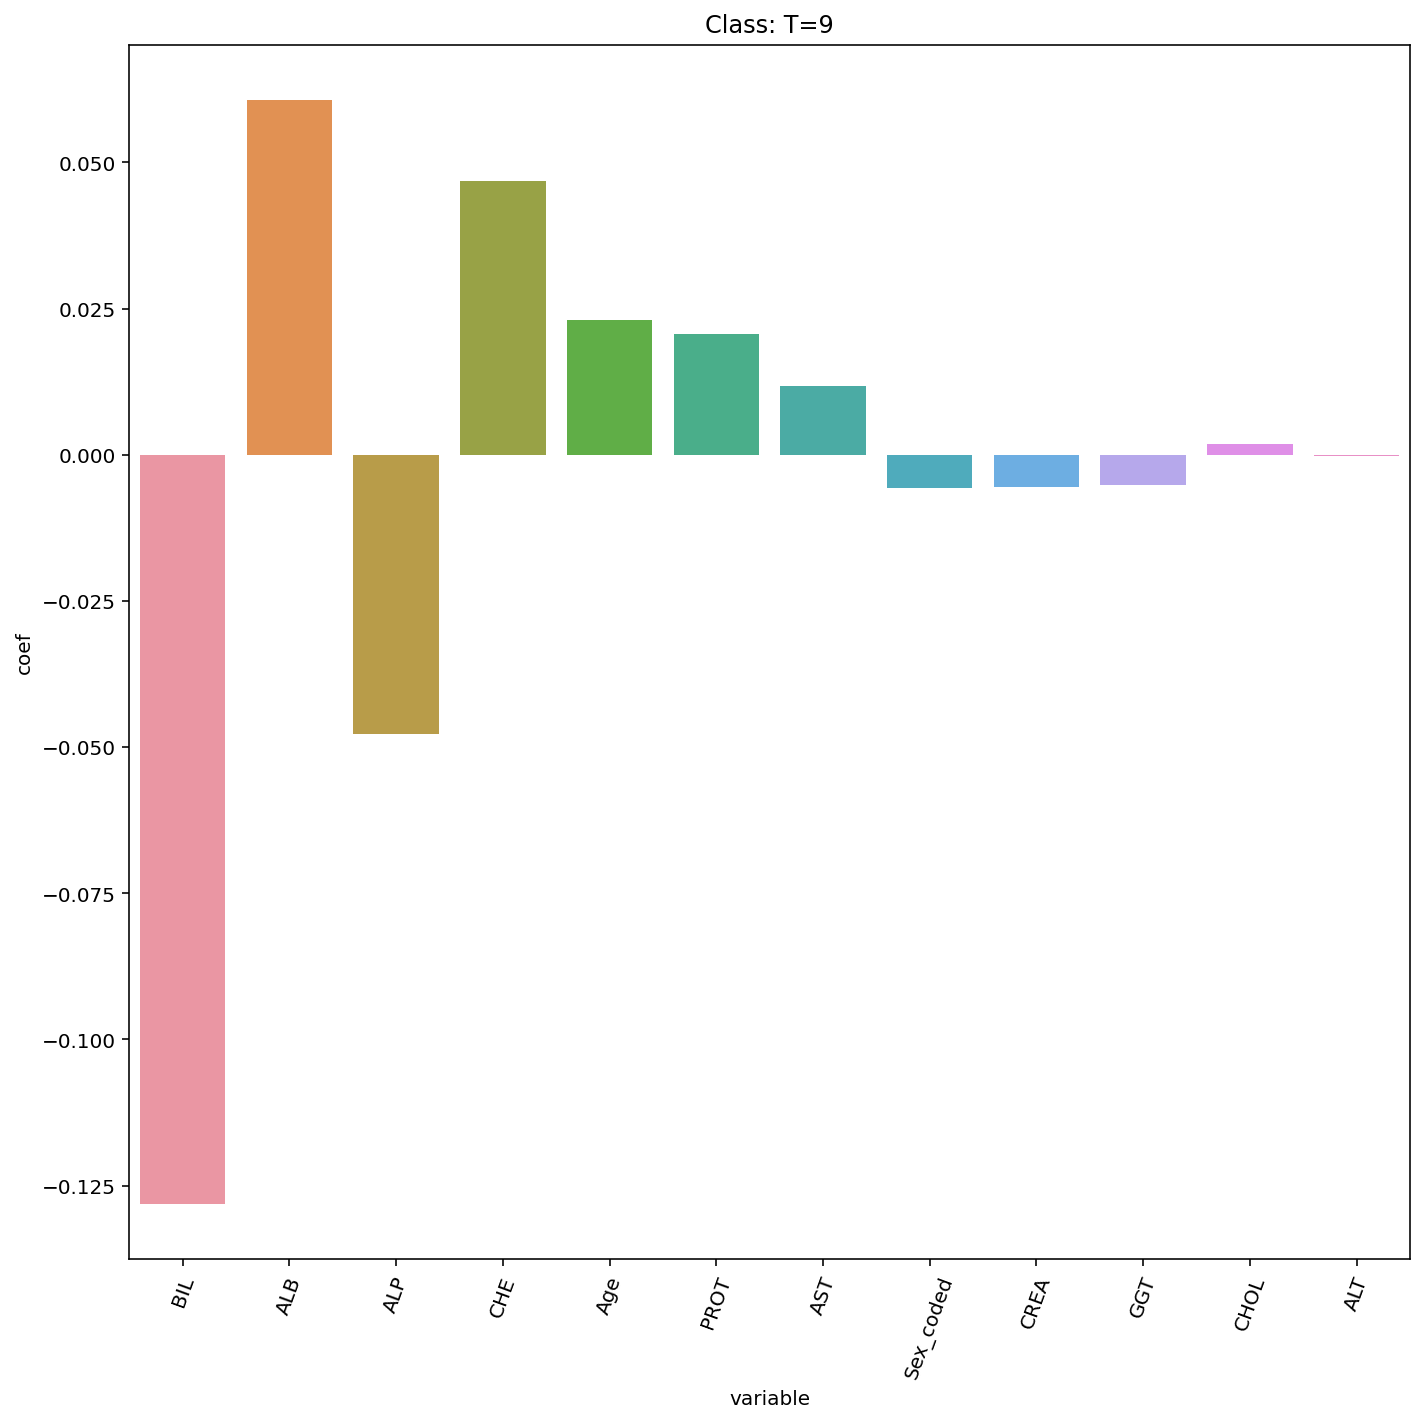

In [98]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
view_coeff(X, svc)

In [97]:
### spliting data set to train and test and enlarge to the train data set and model. 
### not touching test data set, there is no leakage


In [78]:
## Use Forward Feature Selection to pick a good model
show_steps = True  
# start with no predictors
included = []
# keep track of model and parameters
best = {'feature': '', 'r2': 0, 'a_r2': 0}
# create a model object to hold the modelling parameters
model = LogisticRegression(max_iter=20000)
# get the number of cases in the test data
n = X_test.shape[0]

r2_list = []
adjusted_r2_list = []

while True:
    changed = False
    
    if show_steps:
        print('') 

    # list the features to be evaluated
    excluded = list(set(X.columns) - set(included))
    
    if show_steps:
        print('(Step) Excluded = %s' % ', '.join(excluded))  

    # for each remaining feature to be evaluated
    for new_column in excluded:
        
        if show_steps:
            print('(Step) Trying %s...' % new_column)
            print('(Step) - Features = %s' % ', '.join(included + [new_column]))

        # fit the model with the Training data
        fit = model.fit(X_train[included + [new_column]], y_train)
        # calculate the score (R^2 for Regression)
        r2 = fit.score(X_train[included + [new_column]], y_train)
        
        # number of predictors in this model
        k = len(included) + 1
        # calculate the adjusted R^2
        adjusted_r2 = 1 - ( ( (1 - r2) * (n - 1) ) / (n - k - 1) )
        
        if show_steps:
            print('(Step) - Adjusted R^2: This = %.3f; Best = %.3f' % 
                  (adjusted_r2, best['a_r2']))

        # if model improves
        if adjusted_r2 > best['a_r2']:
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r2}
            # flag that found a better model
            changed = True
            if show_steps:
                print('(Step) - New Best!   : Feature = %s; R^2 = %.3f; Adjusted R^2 = %.3f' % 
                      (best['feature'], best['r2'], best['a_r2']))
    # END for
    
    r2_list.append(best['r2'])
    adjusted_r2_list.append(best['a_r2'])

    # if found a better model after testing all remaining features
    if changed:
        # update control details
        included.append(best['feature'])
        excluded = list(set(excluded) - set(best['feature']))
        print('Added feature %-4s with R^2 = %.3f and adjusted R^2 = %.3f' % 
              (best['feature'], best['r2'], best['a_r2']))
    else:
        # terminate if no better model
        print('*'*50)
        break

print('')
print('Resulting features:')
print(', '.join(included))


(Step) Excluded = BIL, CHOL, Sex_coded, ALB, ALT, CREA, AST, GGT, PROT, CHE, Age, ALP
(Step) Trying BIL...
(Step) - Features = BIL
(Step) - Adjusted R^2: This = 0.899; Best = 0.000
(Step) - New Best!   : Feature = BIL; R^2 = 0.900; Adjusted R^2 = 0.899
(Step) Trying CHOL...
(Step) - Features = CHOL
(Step) - Adjusted R^2: This = 0.885; Best = 0.899
(Step) Trying Sex_coded...
(Step) - Features = Sex_coded
(Step) - Adjusted R^2: This = 0.883; Best = 0.899
(Step) Trying ALB...
(Step) - Features = ALB
(Step) - Adjusted R^2: This = 0.885; Best = 0.899
(Step) Trying ALT...
(Step) - Features = ALT
(Step) - Adjusted R^2: This = 0.888; Best = 0.899
(Step) Trying CREA...
(Step) - Features = CREA
(Step) - Adjusted R^2: This = 0.890; Best = 0.899
(Step) Trying AST...
(Step) - Features = AST
(Step) - Adjusted R^2: This = 0.909; Best = 0.899
(Step) - New Best!   : Feature = AST; R^2 = 0.909; Adjusted R^2 = 0.909
(Step) Trying GGT...
(Step) - Features = GGT
(Step) - Adjusted R^2: This = 0.885; Best =

(Step) - Adjusted R^2: This = 0.966; Best = 0.962
(Step) - New Best!   : Feature = CHE; R^2 = 0.967; Adjusted R^2 = 0.966
(Step) Trying ALT...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, ALT
(Step) - Adjusted R^2: This = 0.959; Best = 0.966
(Step) Trying GGT...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, GGT
(Step) - Adjusted R^2: This = 0.966; Best = 0.966
(Step) Trying PROT...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, PROT
(Step) - Adjusted R^2: This = 0.961; Best = 0.966
Added feature CHE  with R^2 = 0.967 and adjusted R^2 = 0.966

(Step) Excluded = CHOL, Sex_coded, ALT, GGT, PROT
(Step) Trying CHOL...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, CHE, CHOL
(Step) - Adjusted R^2: This = 0.966; Best = 0.966
(Step) Trying Sex_coded...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, CHE, Sex_coded
(Step) - Adjusted R^2: This = 0.964; Best = 0.966
(Step) Trying ALT...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, CHE, ALT
(Step) - Adjusted R^2: This =

/Users/sangdonlee/opt/anaconda3/envs/python37-2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(Step) - Adjusted R^2: This = 0.968; Best = 0.968
(Step) Trying Sex_coded...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, CHE, GGT, Sex_coded
(Step) - Adjusted R^2: This = 0.966; Best = 0.968
(Step) Trying ALT...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, CHE, GGT, ALT
(Step) - Adjusted R^2: This = 0.971; Best = 0.968
(Step) - New Best!   : Feature = ALT; R^2 = 0.972; Adjusted R^2 = 0.971
Added feature ALT  with R^2 = 0.972 and adjusted R^2 = 0.971

(Step) Excluded = PROT, CHOL, Sex_coded
(Step) Trying PROT...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, CHE, GGT, ALT, PROT
(Step) - Adjusted R^2: This = 0.966; Best = 0.971
(Step) Trying CHOL...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, CHE, GGT, ALT, CHOL
(Step) - Adjusted R^2: This = 0.970; Best = 0.971
(Step) Trying Sex_coded...
(Step) - Features = AST, ALB, ALP, Age, CREA, BIL, CHE, GGT, ALT, Sex_coded
(Step) - Adjusted R^2: This = 0.970; Best = 0.971
**************************************************

R